# Attribute Importance for Concept Drift - Analysis on the BPI challenge 2015 dataset

The process drift explanation framework is applied on the permit application process of five Dutch municipalities.

## Setup
### Imports

In [1]:
# imports
import helper
import matplotlib.pyplot as plt
import math
import pm4py
import pandas as pd
import numpy as np
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction

### Data settings and event log loading

In [2]:
# specify the file paths for each municipal's log
file_paths = {'mun_1': 'data/real/bpic_2015/BPIC15_1.xes',
                    'mun_2': 'data/real/bpic_2015/BPIC15_2.xes',
                    'mun_3': 'data/real/bpic_2015/BPIC15_3.xes',
                    'mun_4': 'data/real/bpic_2015/BPIC15_4.xes',
                    'mun_5': 'data/real/bpic_2015/BPIC15_5.xes'}
muns = file_paths.keys()

In [3]:
# load the event logs
event_logs = {mun: xes_importer.apply(file_path) for mun, file_path in file_paths.items()}

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1156/1156 [00:07<00:00, 160.10it/s]


## Present basic analysis

In [4]:
def get_basic_stats(event_log, get_attribute_values=False):
    # get some basic statistics (number of events, number of traces, attributes...)
    basic_stats = {}

    # event statistics
    event_stream = pm4py.convert.convert_to_event_stream(event_log)
    number_events = len(event_stream)
    basic_stats['Number of events'] = number_events

    event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)

    if get_attribute_values:
        basic_stats['Event attributes'] = str(sorted(event_attributes))

    number_event_attributes = len(event_attributes)
    basic_stats['Number event attributes'] = number_event_attributes

    # trace statistics
    number_traces = len(event_log)
    basic_stats['Number traces'] = number_traces

    trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
    if get_attribute_values:
        basic_stats['Trace attributes'] = str(sorted(trace_attributes))

    number_trace_attributes = len(trace_attributes)
    basic_stats['Number trace attributes'] = number_trace_attributes

    basic_stats_series = pd.Series(basic_stats)
    return basic_stats_series

In [5]:
basic_stats_individual_logs = {mun: get_basic_stats(event_log) for mun, event_log in event_logs.items()}
all_stats = pd.concat(basic_stats_individual_logs.values(), axis=1)
all_stats.columns = basic_stats_individual_logs.keys()

# export table to latex
path = 'results/latex/bpic_2015_basic_stats.tex'
with open(path, 'w') as file:
    all_stats.to_latex(file, float_format="%.2f", caption='Basic Stats of BPIC 2015 Data Set', label='tab:bpic2015_basic_stats')

all_stats

C:\Users\Lennart\AppData\Local\Temp\ipykernel_24072\3543150072.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  all_stats.to_latex(file, float_format="%.2f", caption='Basic Stats of BPIC 2015 Data Set', label='tab:bpic2015_basic_stats')


,mun_1,mun_2,mun_3,mun_4,mun_5
Number of events,52217,44354,59681,47293,59083
Number event attributes,12,12,12,12,12
Number traces,1199,832,1409,1053,1156
Number trace attributes,15,14,15,15,15


In [6]:
# check if all logs have the same event and trace attributes
event_attributes_per_mun = {mun: pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log) for mun, event_log in event_logs.items()}
trace_attributes_per_mun = {mun: pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log) for mun, event_log in event_logs.items()}
all_event_attributes = set().union(*event_attributes_per_mun.values())
all_trace_attributes = set().union(*trace_attributes_per_mun.values())

print(f'Event attributes: {all_event_attributes}')
print(f'Trace attributes: {all_trace_attributes}')

Event attributes: {'time:timestamp', 'action_code', 'dateFinished', 'monitoringResource', 'org:resource', 'activityNameNL', 'dateStop', 'planned', 'activityNameEN', 'concept:name', 'dueDate', 'question'}
Trace attributes: {'IDofConceptCase', 'Responsible_actor', 'caseStatus', 'termName', 'case_type', 'last_phase', 'caseProcedure', 'startDate', 'parts', 'requestComplete', 'landRegisterID', 'endDate', 'endDatePlanned', 'Includes_subCases', 'SUMleges'}


In [7]:
# build a dictionary that hold the attributes and for which munincipality they apply
# this can be put into a table
attributes_dict = {}
for event_attribute in all_event_attributes:
    truth_array = []
    for mun in muns:
        if event_attribute in event_attributes_per_mun[mun]:
            truth_array.append(True)
        else:
            truth_array.append(False)
    attributes_dict[f'event: {event_attribute}'] = truth_array

for trace_attribute in all_trace_attributes:
    truth_array = []
    for mun in muns:
        if trace_attribute in trace_attributes_per_mun[mun]:
            truth_array.append(True)
        else:
            truth_array.append(False)
    attributes_dict[f'trace: {trace_attribute}'] = truth_array

In [8]:
pd.DataFrame().from_dict(attributes_dict, orient='index', columns=muns)

,mun_1,mun_2,mun_3,mun_4,mun_5
event: time:timestamp,True,True,True,True,True
event: action_code,True,True,True,True,True
event: dateFinished,True,True,True,True,True
event: monitoringResource,True,True,True,True,True
event: org:resource,True,True,True,True,True
event: activityNameNL,True,True,True,True,True
event: dateStop,True,True,True,True,True
event: planned,True,True,True,True,True
event: activityNameEN,True,True,True,True,True
event: concept:name,True,True,True,True,True


All event attributes are the same. One municipal is missing the `endDatePlanned` attribute. This is municipal 2, as can be seen in the attribute value count of this municipal.

Now, get an impression on the values which the attributes hold. For that, municipal 1 is selected.

In [9]:
example_mun = 'mun_1'
trace_attributes = trace_attributes_per_mun[example_mun]
event_attributes = event_attributes_per_mun[example_mun]

display(helper.get_examples_of_event_attributes(event_logs[example_mun], 5, event_attributes))

,monitoringResource,org:resource,activityNameNL,concept:name,question,dateFinished,action_code,activityNameEN,planned,time:timestamp
0,560925,560912,registratie datum publicatie ingekomen aanvraag,01_HOOFD_100,EMPTY,2010-12-13 12:27:10,01_HOOFD_100,registrer date of publishing received request,2010-12-14 12:26:57+01:00,2010-12-15 00:00:00+01:00
1,2670601,2670601,instellen besluitfase:behandeling laten verzonden,08_AWB45_090_2a,EMPTY,2013-11-11 00:00:00,08_AWB45_090_2a,start decision phase permanent suspension sent,2013-11-12 11:17:44+01:00,2013-11-11 00:00:00+01:00
2,560872,560881,activiteiten reguliere procedure,04_BPT_020,Regulier,2011-02-01 12:00:19,04_BPT_020,activities regular procedure,2011-02-02 11:56:19+01:00,2011-02-01 11:56:34+01:00
3,2670601,560872,reguliere procedure zonder MER,04_BPT_005,True,2012-05-03 14:24:38,04_BPT_005,regular procedure without MER,2012-05-04 14:24:02+02:00,2012-05-03 14:24:12+02:00
4,3273854,560912,procedurebevestiging versturen,01_HOOFD_065_1,EMPTY,2012-03-13 15:16:55,01_HOOFD_065_1,send procedure confirmation,2012-03-14 15:15:56+01:00,2012-03-13 15:15:57+01:00


The events fields 'activityNameNL', 'concept:name', 'action_code' and 'activityNameEN' all contain the same information: different representations of the activity that was executed in an event.

The timestamps should also be deleted from the feature analysis. They would always be significantly different as they are expected to increase over time.

In [10]:
selected_event_attributes = ['monitoringResource', 'org:resource', 'question']
selected_event_attributes

['monitoringResource', 'org:resource', 'question']

In [11]:
display(helper.get_examples_of_trace_attributes(event_logs[example_mun], 5, trace_attributes))

,endDate,caseStatus,SUMleges,last_phase,case_type,Responsible_actor,landRegisterID,parts,termName,endDatePlanned,startDate,requestComplete,IDofConceptCase,Includes_subCases
0,2014-05-02 00:00:00+02:00,O,820.50030,Beschikking verzonden,557669,560464,720386,Bouw,Termijn bezwaar en beroep 1,2014-05-02 00:00:00+02:00,2014-01-21 00:00:00+01:00,FALSE,9294844,NaN
1,2012-09-17 00:00:00+02:00,O,7086.08940,Beschikking verzonden,557669,560464,NaN,"Bouw,Milieu (neutraal wijziging)",Termijn bezwaar en beroep 1,NaT,2012-06-14 00:00:00+02:00,FALSE,5186508,J
2,2014-08-15 00:00:00+02:00,G,314.18610,Beschikking verzonden,557669,4901428,NaN,Bouw,Termijn bezwaar en beroep 1,2014-08-15 00:00:00+02:00,2014-05-28 00:00:00+02:00,TRUE,NaN,NaN
3,2011-09-13 00:00:00+02:00,G,541.71180,Vergunning verleend,557669,4901428,NaN,Bouw,Termijn bezwaar en beroep 1,NaT,2011-07-29 00:00:00+02:00,FALSE,3734467,J
4,2012-02-14 14:42:01+01:00,G,120.16122,Procedure afgebroken,557669,560912,NaN,Bouw,NaN,NaT,2011-06-22 00:00:00+02:00,TRUE,3538779,J


Also for the trace attributes, the date fields should not be analyzed for drift. This gets rid of the `endDatePlanned` attribute that is not available for all municipal logs.

Also the fields 'IDofConceptCase' and 'landRegisterID' are excluded from the analysis as they are holding identifying numbers.

In [12]:
selected_trace_attributes = ['caseStatus', 'SUMleges', 'last_phase', 'case_type', 'Includes_subCases', 'Responsible_actor', 'parts', 'termName', 'requestComplete', 'caseProcedure']
selected_trace_attributes

['caseStatus',
 'SUMleges',
 'last_phase',
 'case_type',
 'Includes_subCases',
 'Responsible_actor',
 'parts',
 'termName',
 'requestComplete',
 'caseProcedure']

In [13]:
attribute_level_type_list = helper.automatically_get_attributes_and_data_types(event_logs[example_mun], selected_trace_attributes, selected_event_attributes)
attribute_level_type_list

[('caseStatus', 'trace', 'categorical'),
 ('SUMleges', 'trace', 'continuous'),
 ('last_phase', 'trace', 'categorical'),
 ('case_type', 'trace', 'categorical'),
 ('Responsible_actor', 'trace', 'categorical'),
 ('parts', 'trace', 'categorical'),
 ('termName', 'trace', 'categorical'),
 ('requestComplete', 'trace', 'categorical'),
 ('question', 'event', 'categorical'),
 ('monitoringResource', 'event', 'categorical'),
 ('org:resource', 'event', 'categorical'),
 ('caseProcedure', 'trace', 'categorical'),
 ('Includes_subCases', 'trace', 'categorical')]

### Configure Primary Drift Detector

In [14]:
# alternative 1: ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=200,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [15]:
secondary_window_size = 200
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by * 0.5)
secondary_rho = math.ceil(secondary_window_size / secondary_slide_by * 0.01)
secondary_threshold = 0.05

change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_type_list,
                                                                        secondary_window_generator, 
                                                                        change_point_extractor,
                                                                        min_samples_per_test=5)

## Run the Change Point Explainer

In [16]:
changes_per_mun = {}
for mun, event_log in event_logs.items():
    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    changes_per_mun[mun] = changes

exporting log, completed traces :: 100%|██████████| 1199/1199 [00:05<00:00, 209.44it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmps2v4564p\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 508 (Thu Jun 14 00:00:00 CEST 2012) after reading 635 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 886 (Thu Jan 30 11:00:31 CET 2014) after reading 1085 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 832/832 [00:04<00:00, 184.22it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpkj13i7lf\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'


c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpzbcs6ls1\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 854 (Thu May 02 12:18:31 CEST 2013) after reading 1088 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 1053/1053 [00:04<00:00, 231.64it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpxqs2q8qk\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'


c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpococptr1\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n'


c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

First, the primary change points are analyzed. ProDrift was used as the primary change detector, which resulted in the following change plots:

Municipal 1:

![alt text](results/bpic_2015/pro_drift/mun_1.png "Primary Change Series Municipal 1")

Municipal 2:

![alt text](results/bpic_2015/pro_drift/mun_2.png "Primary Change Series Municipal 2")

Municipal 3:

![alt text](results/bpic_2015/pro_drift/mun_3.png "Primary Change Series Municipal 3")

Municipal 4:

![alt text](results/bpic_2015/pro_drift/mun_4.png "Primary Change Series Municipal 4")

Municipal 5 :

![alt text](results/bpic_2015/pro_drift/mun_5.png "Primary Change Series Municipal 5")


Because an initial window size of 200 traces was chosen, first measurements of p-value start at trace 400 (the composite window has the size of two times that of a single window). For municipal 1, the process continuously shows very low p-values and registers change points around trace 510 and trace 890. For municipal 2, no change point was found. Municipal 3 has a change point around trace 850. The p-value continuous to be very low from that point onwards, indicating ongoing change in the process. Municpal 4 has drops in p-value at around trace 440 and 1040. However, no change point was detected because either the threshold was not breached or not breached for long enough. The same goes for municipal 5 for changes at trace 650 and 950 onwards.

Overall, the primary change detector only detected changes for 2 out of the 5 municipals, municipal 1 and municipal 3. If the threshold where increased, more changes had been detected, e.g., those for municipal 4 and 5 where values have been recorded close to the current threshold.

In the next step of the analysis, the secondary change detectors for municipal 1 and municipal 3 are evaluated.

In [17]:
for mun in ['mun_1', 'mun_3']:
    print(f'Change Point Explanations {mun}')
    display(changes_per_mun[mun].to_table())

# put the cpes into latex tables
mun_1_table = changes_per_mun['mun_1'].to_table()

# export table to latex
path = 'results/latex/bpi2015_mun_1_table.tex'
with open(path, 'w') as file:
    mun_1_table.to_latex(file, float_format="%.2f", index=False)

# put the cpes into latex tables
mun_3_table = changes_per_mun['mun_3'].to_table()

# export table to latex
path = 'results/latex/bpi2015_mun_3_table.tex'
with open(path, 'w') as file:
    mun_3_table.to_latex(file, float_format="%.2f", index=False)

Change Point Explanations mun_1


,Primary Change Point,Detector,Secondary Change Point,Lag
0,508,trace: SUMleges,479,-29
1,508,trace: requestComplete,539,31
2,508,trace: caseProcedure,439,-69
3,508,trace: Includes_subCases,399,-109
4,508,trace: requestComplete,399,-109
5,886,trace: caseStatus,1068,182
6,886,event: org:resource,1088,202


Change Point Explanations mun_3


,Primary Change Point,Detector,Secondary Change Point,Lag
0,854,trace: caseProcedure,794,-60
1,854,trace: SUMleges,754,-100
2,854,trace: Includes_subCases,714,-140
3,854,event: org:resource,554,-300
4,854,trace: requestComplete,554,-300


C:\Users\Lennart\AppData\Local\Temp\ipykernel_24072\1770823923.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mun_1_table.to_latex(file, float_format="%.2f", index=False)
C:\Users\Lennart\AppData\Local\Temp\ipykernel_24072\1770823923.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mun_3_table.to_latex(file, float_format="%.2f", index=False)


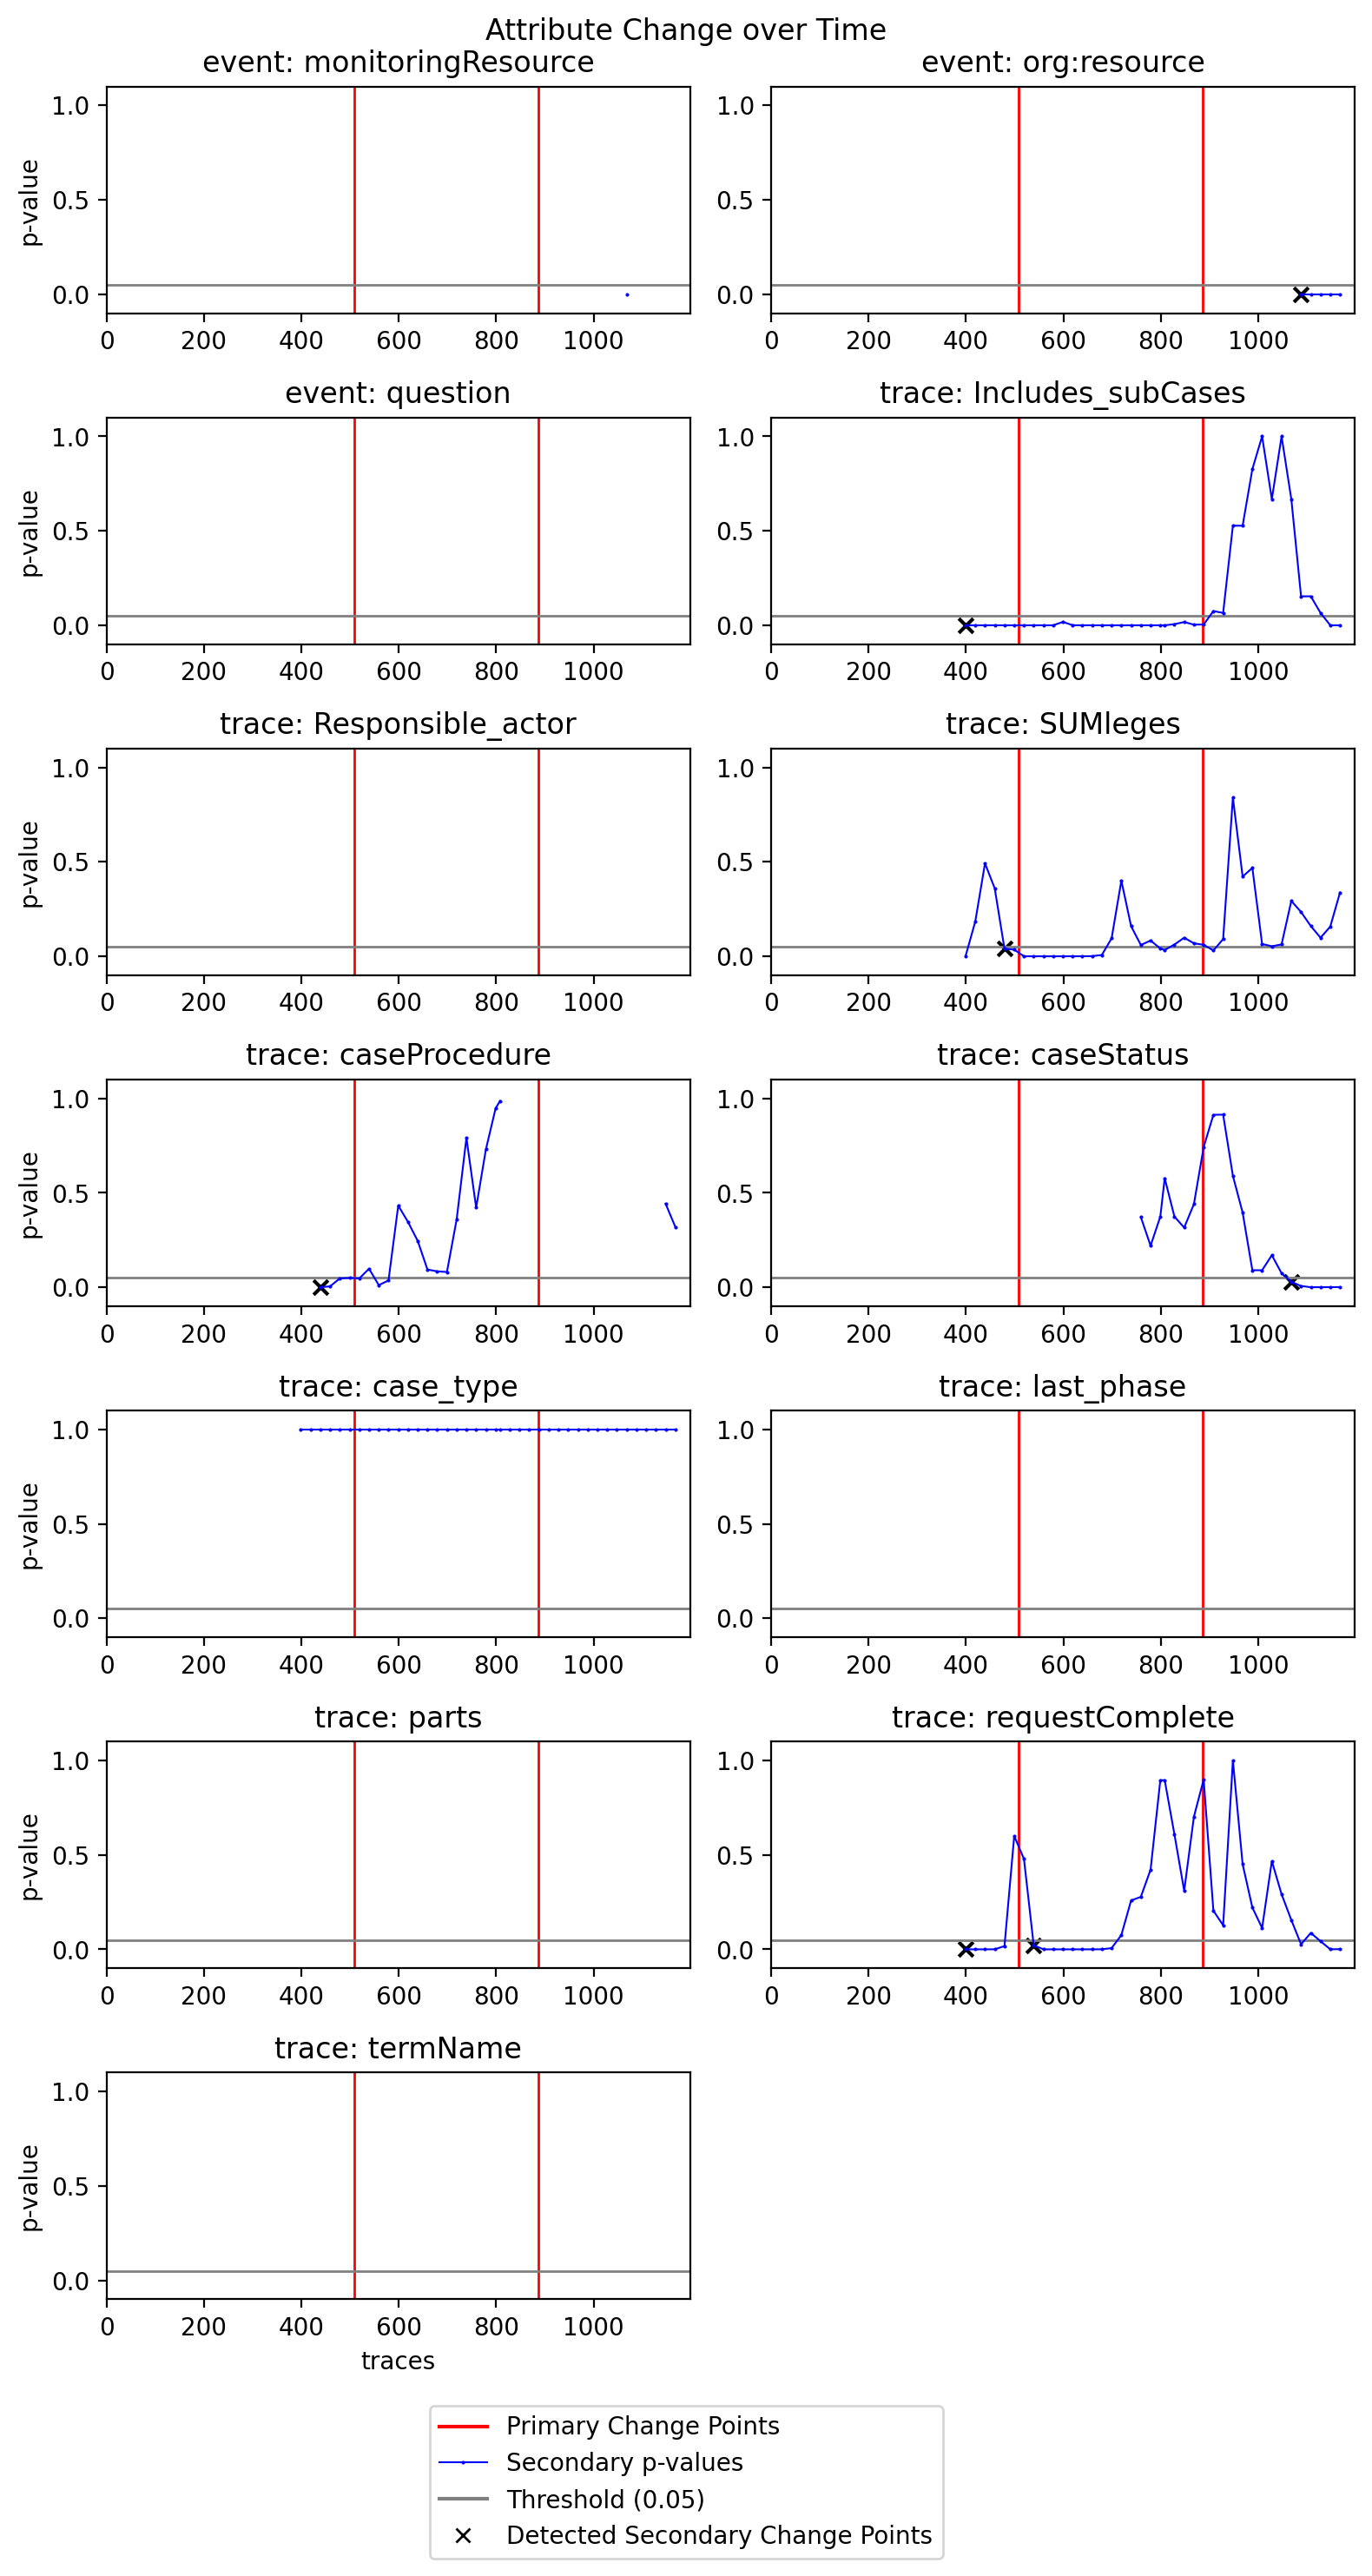

In [18]:
# plot the change point explanations for municipal 1
changes_per_mun['mun_1'].plot(offset_legend=-0.07)
pass

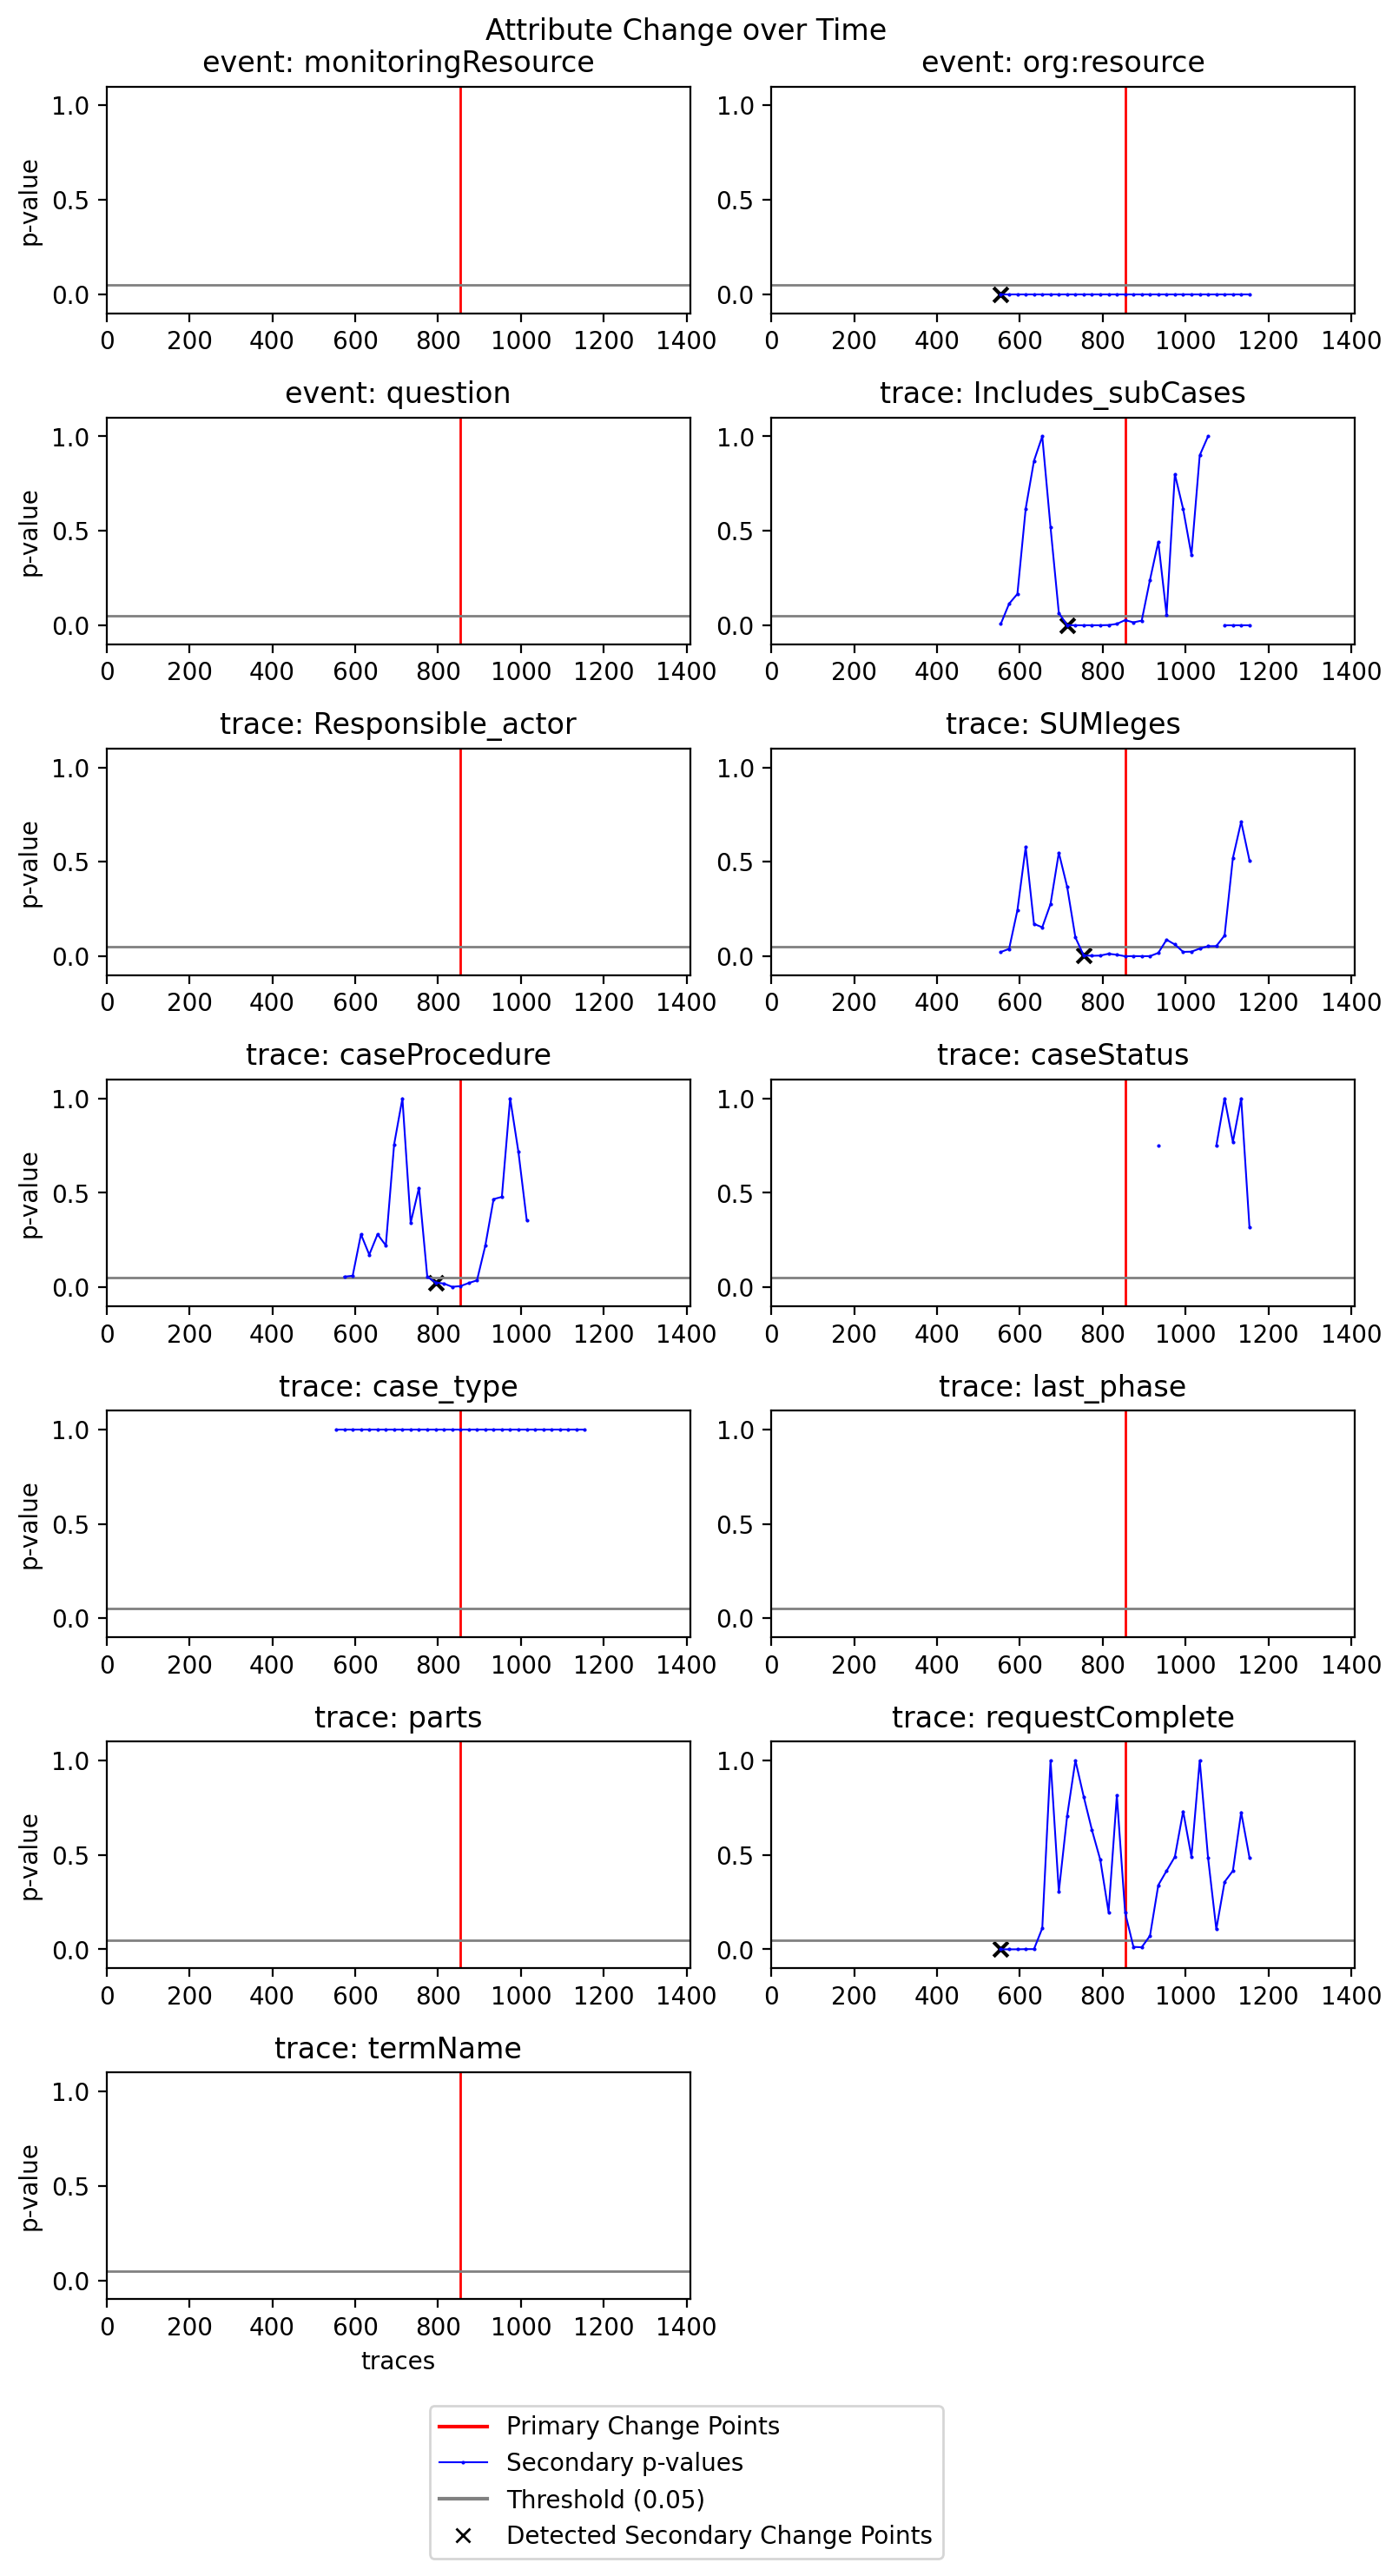

In [19]:
# plot the change point explanations for municipal 3
changes_per_mun['mun_3'].plot(offset_legend=-0.07)
pass

Create new plots for both municipals with only the change series that have (mostly) measurable p-values.

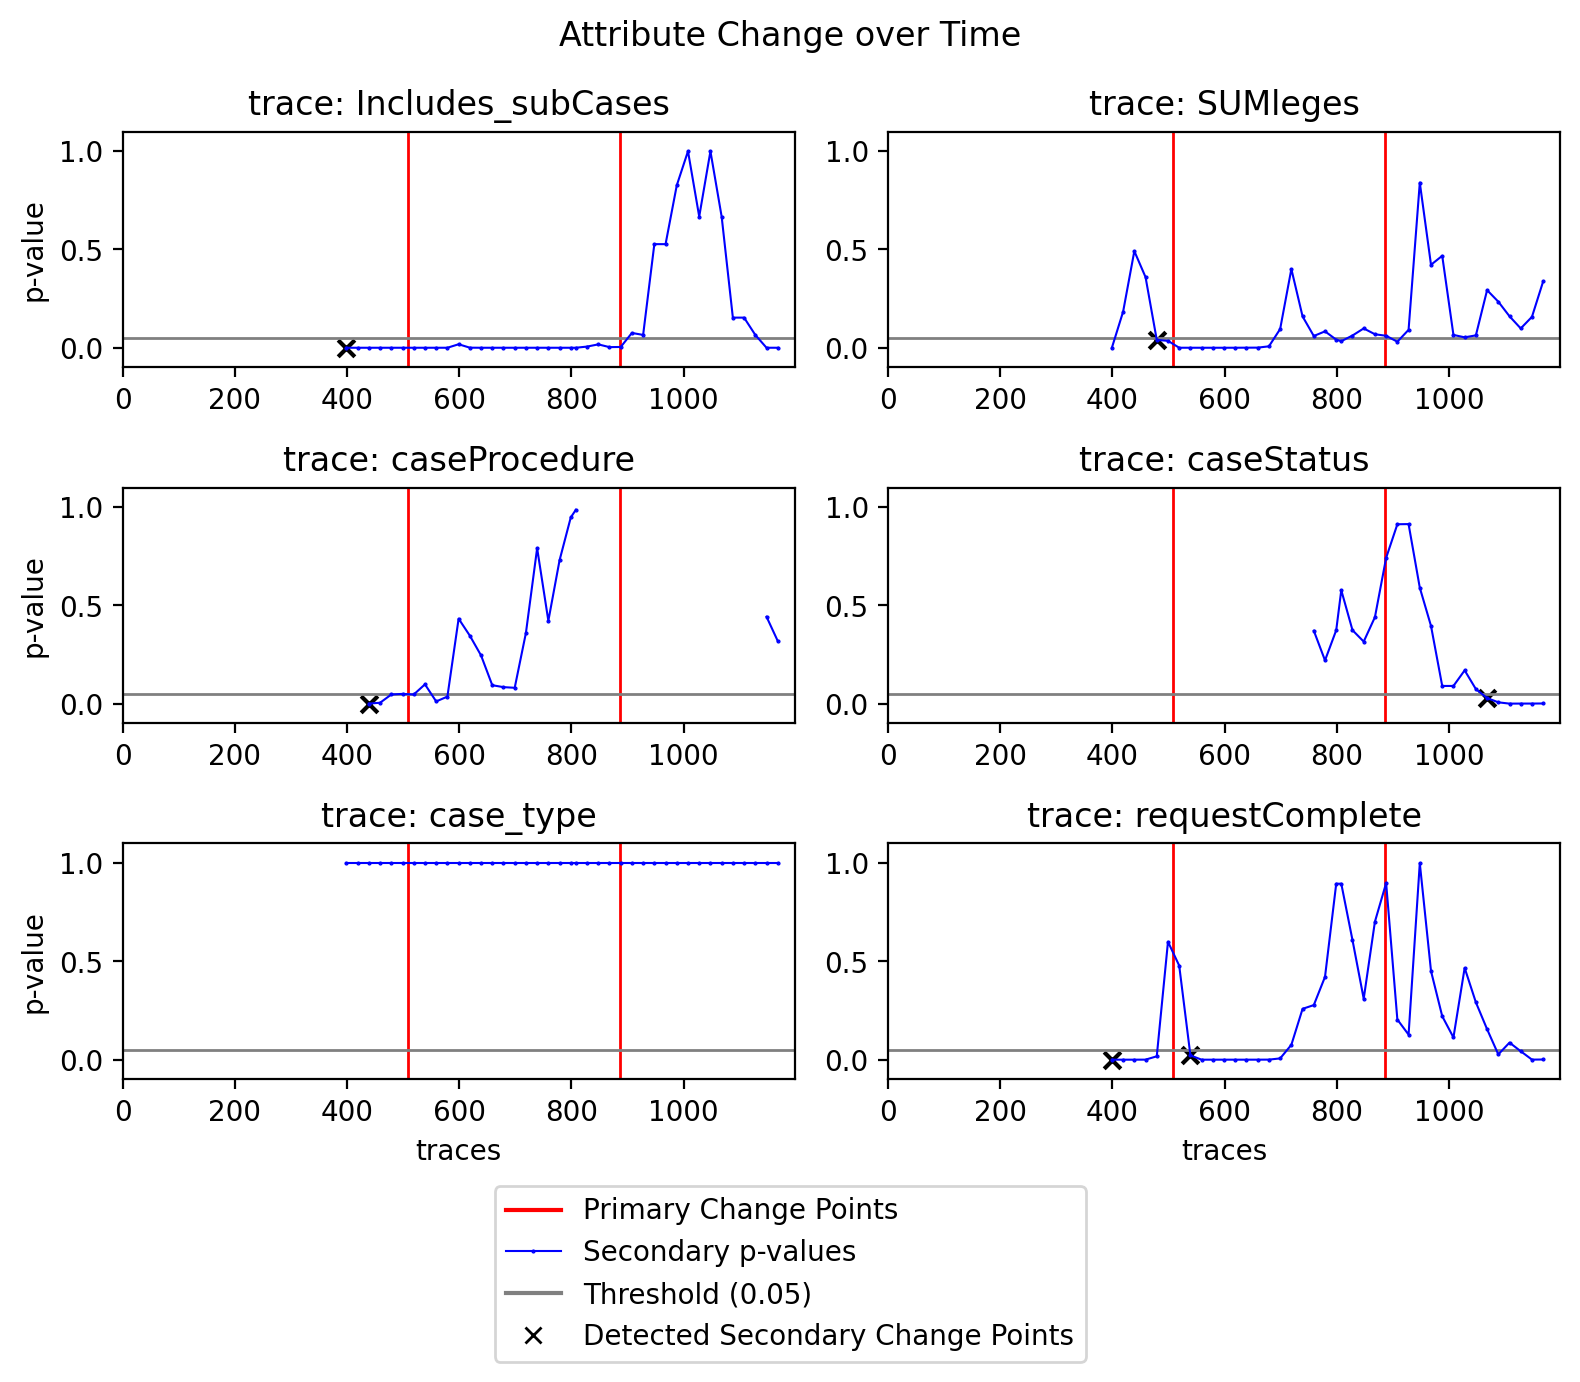

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [20]:
# plot only change series with enough measurements, municipal 1
from operator import itemgetter

secondary_dd_list_mun_1 = ['trace: Includes_subCases',
 'trace: SUMleges',
 'trace: caseProcedure',
 'trace: case_type',
 'trace: caseStatus',
 'trace: requestComplete']

# get the according drift detectors
mun_1_selected_drift_detectors = {secondary_dd: changes_per_mun['mun_1'].secondary_dd_result_dictionary[secondary_dd] for secondary_dd in secondary_dd_list_mun_1}

# build a new drift explanation objects
drift_explanations_mun_1 = drift_explanation.DriftExplanationResult(changes_per_mun['mun_1'].primary_dd_result, mun_1_selected_drift_detectors, None)

drift_explanations_mun_1.plot()

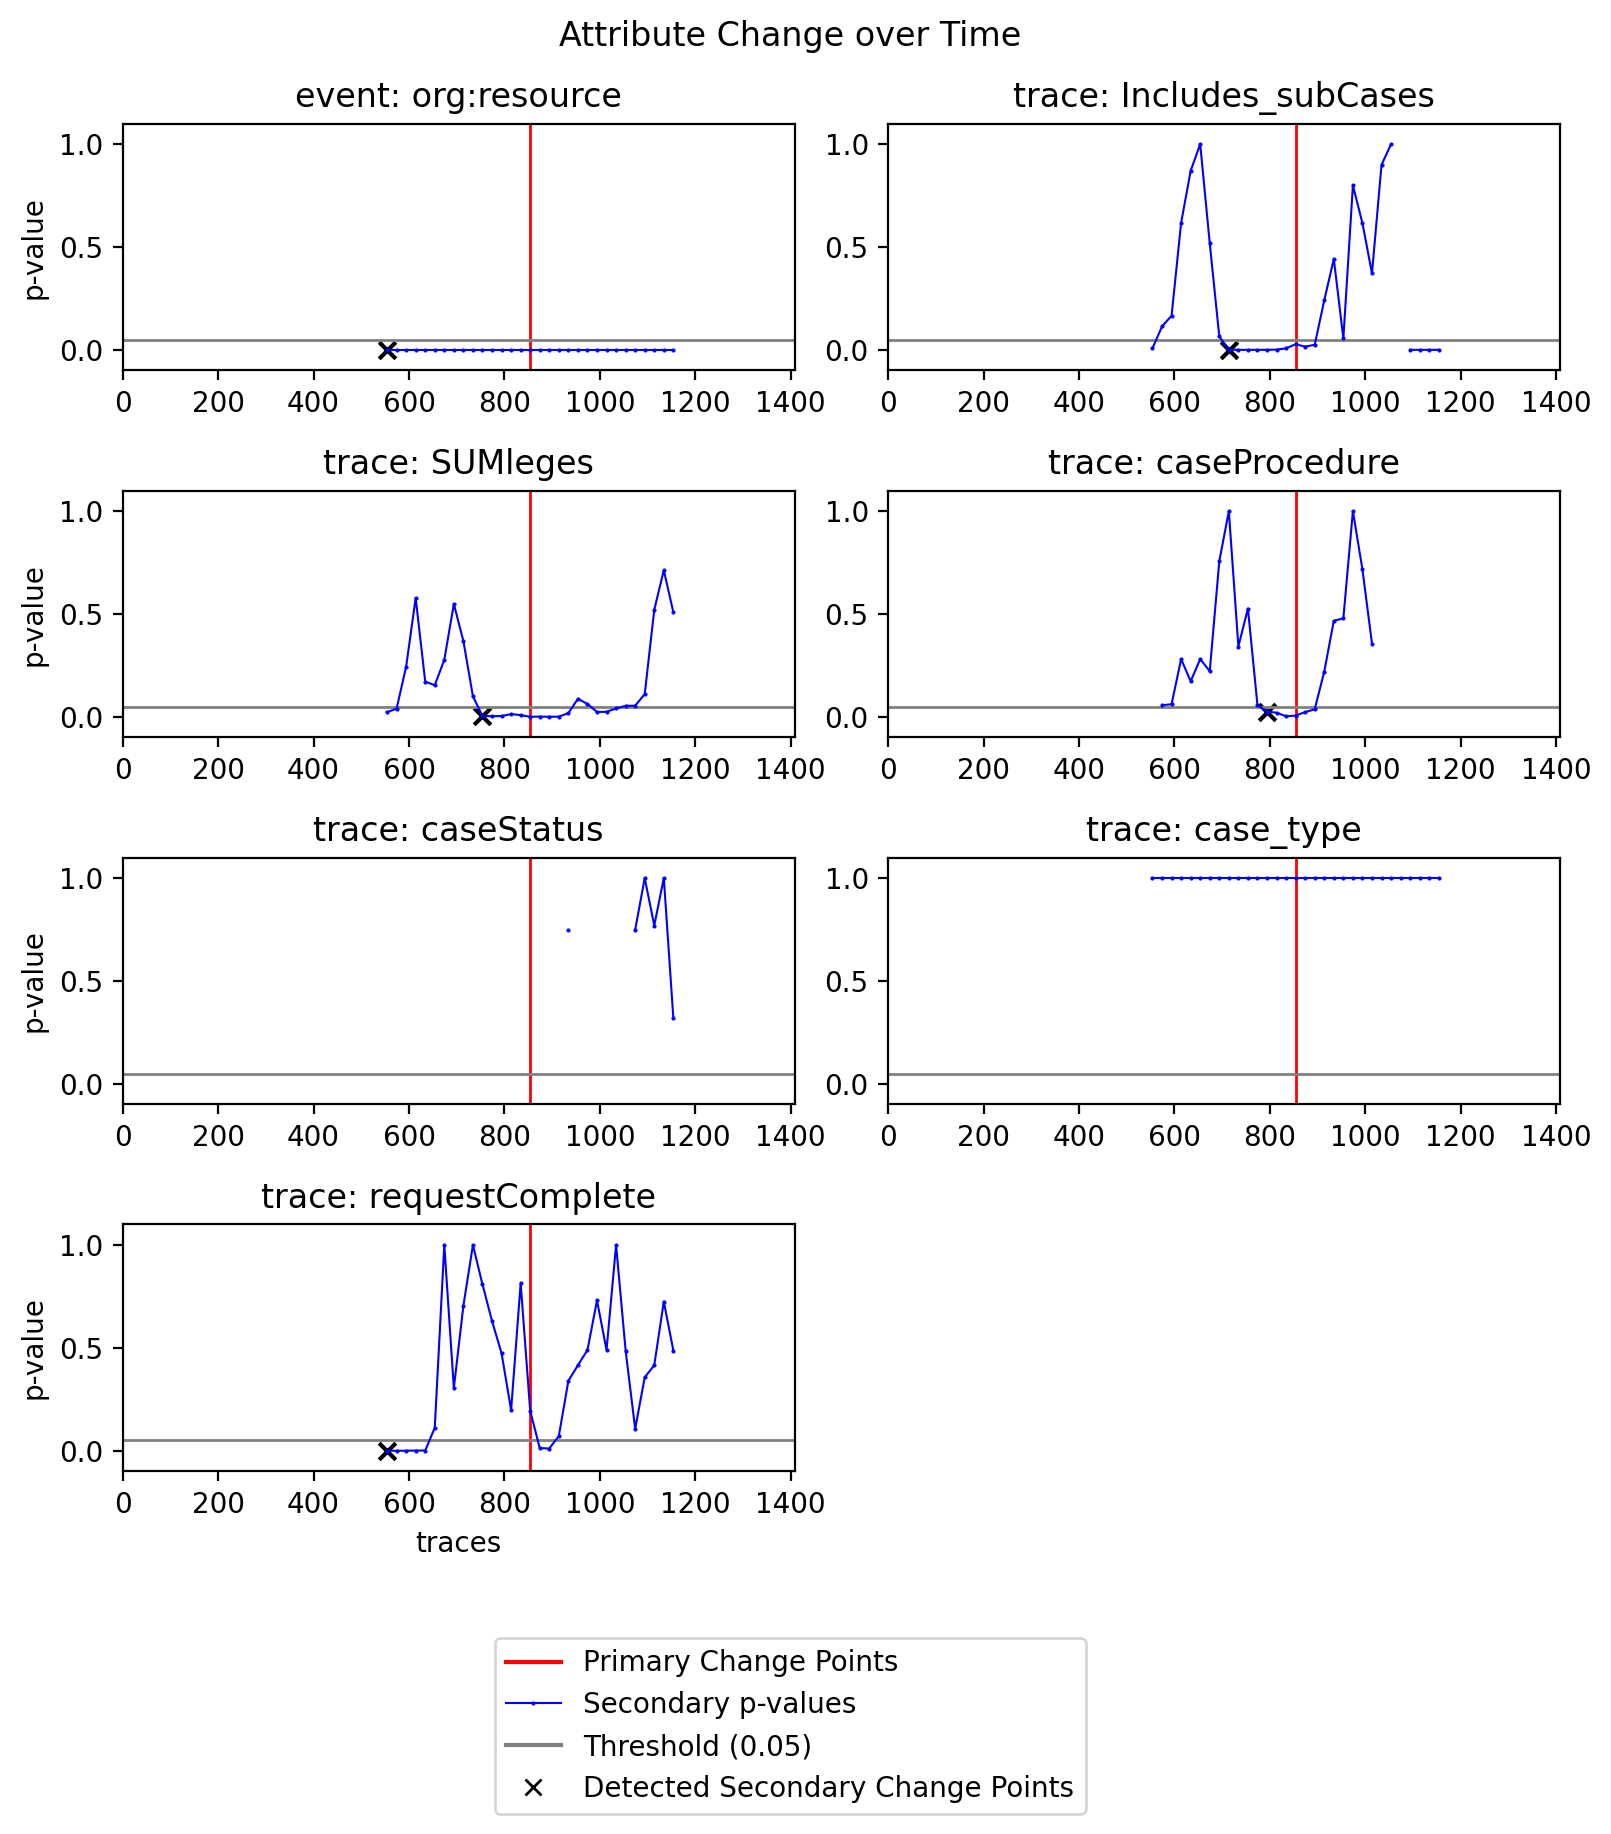

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
# plot only change series with enough measurements, municipal 3
from operator import itemgetter

secondary_dd_list_mun_3 = [
 'event: org:resource',
 'trace: Includes_subCases',
 'trace: SUMleges',
 'trace: caseProcedure',
 'trace: case_type',
 'trace: caseStatus',
 'trace: requestComplete']

# get the according drift detectors
mun_3_selected_drift_detectors = {secondary_dd: changes_per_mun['mun_3'].secondary_dd_result_dictionary[secondary_dd] for secondary_dd in secondary_dd_list_mun_3}

# build a new drift explanation objects
drift_explanations_mun_3 = drift_explanation.DriftExplanationResult(changes_per_mun['mun_3'].primary_dd_result, mun_3_selected_drift_detectors, None)

drift_explanations_mun_3.plot()

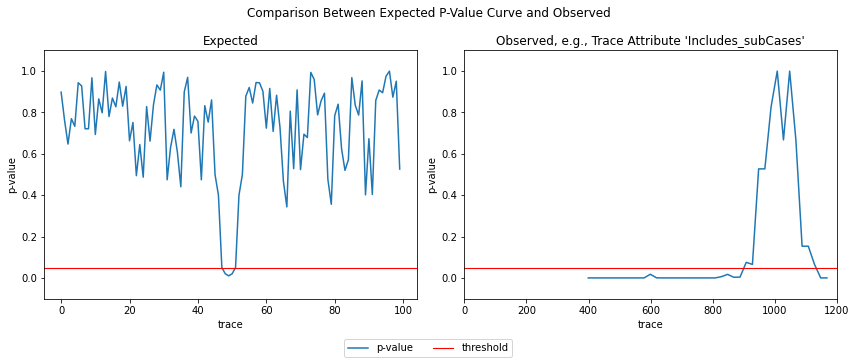

In [40]:
# show a graph with two sub-figures - the idealized p-value graph and the observed graph
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Comparison Between Expected P-Value Curve and Observed')


#### Build subplot for ideal p-value recording
plt.subplot(1, 2, 1)

# show an idealized p-value graph
import math
import matplotlib.pyplot as plt

array = np.ones(100)

# add some random noise
array = [value - abs(np.random.normal(0, 0.3)) for value in array]

# add the drop of p-value for around point 50
array[45] = 0.5
array[46] = 0.4
array[47] = 0.05
array[48] = 0.02
array[49] = 0.01
array[50] = 0.02
array[51] = 0.05
array[52] = 0.4
array[53] = 0.5

# convert to pandas series for plotting
pd.Series(array).plot(title='Expected',
                    ylabel='p-value',
                    xlabel='trace')
plt.ylim(-0.1, 1.1)
plt.axhline(0.05, color='red', linewidth=1.1)

#### Show subplot for actual recorded p-values
plt.subplot(1, 2, 2)

# get a change series
change_series = changes_per_mun['mun_1'].secondary_dd_result_dictionary['trace: Includes_subCases'].change_series
change_series.plot(title='Observed, e.g., Trace Attribute \'Includes_subCases\'',
                    ylabel='p-value',
                    xlabel='trace')

plt.ylim(-0.1, 1.1)
plt.xlim(0, 1200)

threshold_line = plt.axhline(0.05, color='red', linewidth=1.1, label='threshold')

fig.tight_layout() 
fig.subplots_adjust(bottom=0.17)   ##  Need to play with this number.

fig.legend(labels=['p-value', 'threshold'], loc="lower center", ncol=2)

#plt.tight_layout()

plt.show()


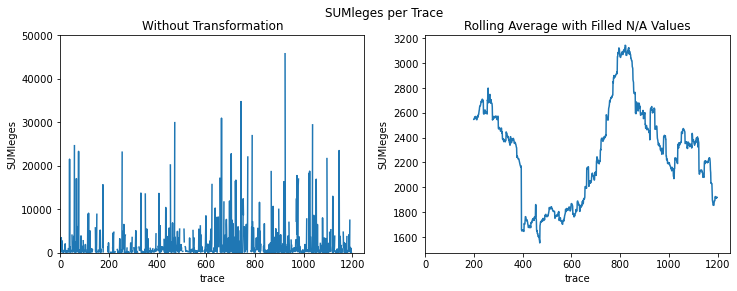

In [35]:
# maybe just showing the moving average of SUMleges provides further insights
fig = plt.figure(figsize=(12, 4))
fig.suptitle('SUMleges per Trace')

plt.subplot(1, 2, 1)

fe = feature_extraction.AttributeFE('trace', 'SUMleges')
sumleges_values = fe.extract(event_logs['mun_1'])
sumleges_series = pd.Series(sumleges_values)

sumleges_series.plot()
plt.ylim(0, 50000)
plt.xlim(0, 1250)
plt.ylabel('SUMleges')
plt.xlabel('trace')
plt.title('Without Transformation')

# second subplot with rolling average and filled na values
plt.subplot(1, 2, 2)

sumleges_series_fillna = sumleges_series.fillna(sumleges_series.mean())
sumleges_ma = sumleges_series_fillna.rolling(200, min_periods=200, center=False).mean()
sumleges_ma.plot()
# plt.ylim(0, 50000)
plt.xlim(0, 1250)
plt.ylabel('SUMleges')
plt.xlabel('trace')
plt.title('Rolling Average with Filled N/A Values')

# plt.tight_layout()
plt.show()

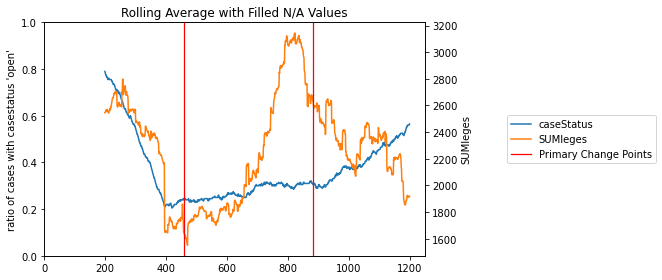

In [50]:
# plot the ratio of open cases for municipal 1
# plot first axis
fig = plt.figure(figsize=(8, 4))



fe = feature_extraction.AttributeFE('trace', 'caseStatus')
casestatus_values = fe.extract(event_logs['mun_1'])
casestatus_series = pd.Series(casestatus_values)
casestatus_series = (casestatus_series == 'O')
casestatus_series = casestatus_series.astype('int')

casestatus_series_fillna = casestatus_series.fillna(casestatus_series.mean())
casestatus_ma = casestatus_series_fillna.rolling(200, min_periods=200, center=False).mean()
ax1 = casestatus_ma.plot()
plt.ylim(0, 1)
plt.xlim(0, 1250)
plt.ylabel('ratio of cases with casestatus \'open\'')

# add the change point line
ax2 = sumleges_ma.plot(secondary_y=True)
plt.ylabel('SUMleges')
plt.xlabel('trace')

ax2.axvline(460, color='red', linewidth=1.25, label='Change Point')
ax2.axvline(880, color='red', linewidth=1.25)

lines_1, _ = ax1.get_legend_handles_labels()
lines_2, _ = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = ['caseStatus', 'SUMleges', 'Primary Change Points']


plt.title('Rolling Average with Filled N/A Values')

# Shrink current axis by 20%
box = ax2.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(lines, labels,loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()

In [ ]:
# show the positions of highest p-values for the caseProcedure attribute
changes_per_mun['mun_3'].secondary_dd_result_dictionary['trace: caseProcedure'].change_series.sort_values(ascending=False)[:5]

713    1.000000
973    1.000000
693    0.877713
993    0.716177
753    0.526523
dtype: float64

In [ ]:
# get the data from the two windows before/after the steady state
window_1_start = 314
window_1_end = 713
window_2_start = 574
window_2_end = 973

# extract the attributes for each data window
# build an attribute feature extractor
fe = feature_extraction.AttributeFE('trace', 'caseProcedure')
event_log = event_logs['mun_3']

# extract the attribute arrays
attribute_values_window_1_array = fe.extract(event_log[window_1_start:window_1_end+1])
attribute_values_window_2_array = fe.extract(event_log[window_2_start:window_2_end+1])

# construct into series with correct trace indeces
attribute_values_window_1 = pd.Series(attribute_values_window_1_array, index=range(window_1_start, window_1_end+1))
attribute_values_window_2 = pd.Series(attribute_values_window_2_array, index=range(window_2_start, window_2_end+1))

# replace None values with string 'None' for plotting purposes
attribute_values_window_1 = attribute_values_window_1.fillna('None')
attribute_values_window_2 = attribute_values_window_2.fillna('None')

# show unique values
value_counts_win_1 = attribute_values_window_1.value_counts()
value_counts_win_2 = attribute_values_window_2.value_counts()

print('Value Counts Window 1')
display(value_counts_win_1)
print('Value Counts Window 2')
display(value_counts_win_2)

# build a results dataframe
df = pd.DataFrame([value_counts_win_1, value_counts_win_2], index=['Before CP', 'After CP']).transpose()
df.loc['Uitgebreid Ratio'] = df.loc['Uitgebreid'] / df.sum()
display(df)

# write to latex table
path = 'results/latex/bpic_2015_mun_3_case_procedure.tex'
with open(path, 'w') as file:
    df.to_latex(file, float_format="%.2f")

Value Counts Window 1


None          356
Uitgebreid     44
dtype: int64

Value Counts Window 2


None          366
Uitgebreid     34
dtype: int64

,Before CP,After CP
None,356.00,366.000
Uitgebreid,44.00,34.000
Uitgebreid Ratio,0.11,0.085


C:\Users\Lennart\AppData\Local\Temp\ipykernel_18772\840381614.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(file, float_format="%.2f")


# Old Analysis that can be deleted
#TODO

In [ ]:
# plot only change series with enough measurements, municipal 2
from operator import itemgetter

secondary_dd_list_mun_2 = ['trace: Includes_subCases',
 'trace: SUMleges',
 'trace: caseProcedure',
 'trace: case_type',
 'trace: caseStatus',
 'trace: requestComplete']

# get the according drift detectors
mun_1_selected_drift_detectors = {secondary_dd: changes_per_mun['mun_1'].secondary_dd_result_dictionary[secondary_dd] for secondary_dd in secondary_dd_list_mun_1}

# build a new drift explanation objects
drift_explanations_mun_1 = drift_explanation.DriftExplanationResult(changes_per_mun['mun_1'].primary_dd_result, mun_1_selected_drift_detectors, None)

drift_explanations_mun_1.plot()

In [ ]:
mun_1_selected_drift_detectors[1]

KeyError: 1

In [ ]:
changes_per_mun['mun_1'].secondary_dd

AttributeError: 'DriftExplanationResult' object has no attribute 'secondar'

Many attributes show continuous change (p-values less than the threshold) and there is no attribute which (approximately) follows an idealized p-value curve, see graph below.

Analysis of trace attribute SUMleges


C:\Users\Lennart\AppData\Local\Temp\ipykernel_18772\311321172.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['before CP', 'after CP'],


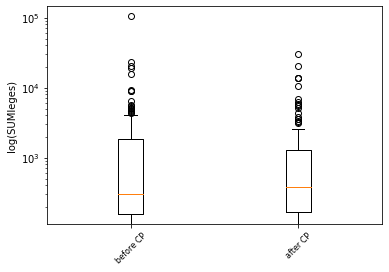

In [ ]:
before_cp, after_cp = helper.get_attribute_values_around_cp(event_logs['mun_1'], 'trace', 'SUMleges', 279, 200)
# delete the None values
before_cp = [x for x in before_cp if x is not None]
after_cp = [x for x in after_cp if x is not None]

# create scatterplot
data = [before_cp, after_cp]
fig, ax = plt.subplots()
#ax.set_title("'SUMleges' Attribute Value Distribution Before and After Change Point")
ax.set_ylabel('log(SUMleges)')
ax.set_xticklabels(['before CP', 'after CP'],
                    rotation=45, fontsize=8)
ax.boxplot(data)
ax.set_yscale('log')

plt.show()

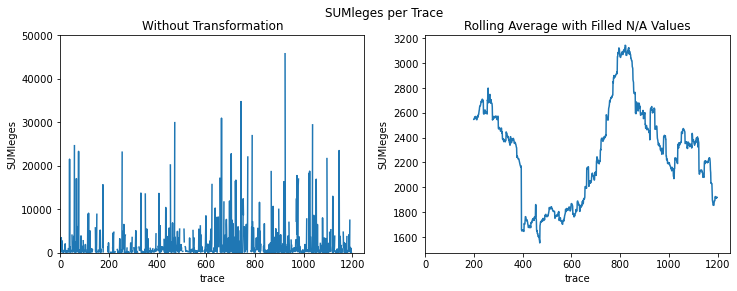

In [ ]:
# before the change point, there is a group of outliers between 10000 and 12000, inspect these further
series_before_cp = pd.Series(before_cp).sort_values()
series_after_cp = pd.Series(after_cp).sort_values()


print('Top 10:')
display(series_before_cp[-10:])
display(series_after_cp[-10:])

print()
print('Costs over 15000:')
print('Before Change Point:')
print(list(series_before_cp[series_before_cp > 15000]))
print('After Change Point:')
print(list(series_after_cp[series_after_cp > 15000]))

Top 10:


44       5727.5610
109      6524.0444
49       8852.8070
25       8854.3660
28       9110.0060
66      15663.0240
105     19060.5590
14      20527.1170
104     23132.1900
69     104549.7000
dtype: float64

125     5705.8706
95      5780.5522
96      6234.3223
136     6883.8790
114    10422.1940
49     13509.4120
91     13657.7800
35     13743.4540
128    20195.1350
145    29926.2480
dtype: float64


Costs over 15000:
Before Change Point:
[15663.024, 19060.559, 20527.117, 23132.19, 104549.7]
After Change Point:
[20195.135, 29926.248]


There are much fewer high values after the change point compared to before. More information on these cases would be interesting.

In [ ]:
selected_traces = []
for trace in event_logs['mun_1'][80:280]:
    trace_attributes = trace.attributes
    if ('SUMleges' in trace_attributes) and trace_attributes['SUMleges'] > 15000:
        selected_traces.append(trace_attributes)

df = pd.DataFrame(selected_traces)
df = df[selected_trace_attributes]
df = df.sort_values('SUMleges', ascending=False)

# export table to latex
path = 'results/latex/bpic_2015_SUMleges_examples.tex'
with open(path, 'w') as file:
    df.to_latex(file, float_format="%.2f", index=False)

df

C:\Users\Lennart\AppData\Local\Temp\ipykernel_18772\1488914824.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(file, float_format="%.2f", index=False)


,caseStatus,SUMleges,last_phase,case_type,Includes_subCases,Responsible_actor,parts,termName,requestComplete,caseProcedure
2,O,104549.700,Aanvraag ontvangen,557669,J,560464,"Bouw,Handelen in strijd met regels RO,Sloop",NaN,TRUE,NaN
3,G,23132.190,Vergunning verleend,557669,J,4901428,Bouw,NaN,TRUE,NaN
0,O,20527.117,Beschikking verzonden,557669,NaN,560912,"Bouw,Handelen in strijd met regels RO",Termijn bezwaar en beroep 1,TRUE,NaN
4,O,19060.559,Vergunning verleend,557669,J,560464,Bouw,NaN,TRUE,Regulier
1,O,15663.024,Aanvraag ontvangen,557669,NaN,2670601,Bouw,Termijn tot besluit,FALSE,Uitgebreid


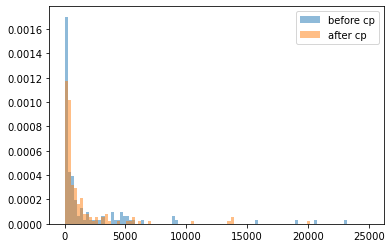

In [ ]:
import numpy as np
bins = np.linspace(0, 25000, 100)
plt.hist(before_cp, bins, alpha=0.5, label='before cp', density=True)
plt.hist(after_cp, bins, alpha=0.5, label='after cp', density=True)
plt.legend(loc='upper right')
plt.show()


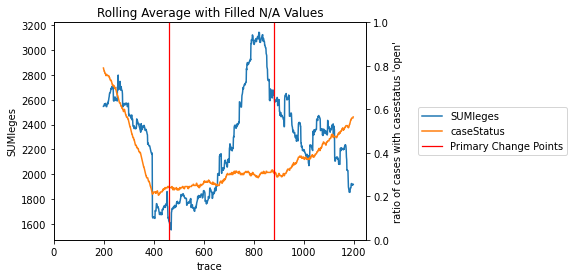

In [ ]:
# plot first axis
fig = plt.figure(figsize=(7, 4))

ax1 = sumleges_ma.plot()
plt.ylabel('SUMleges')
plt.xlabel('trace')

fe = feature_extraction.AttributeFE('trace', 'caseStatus')
casestatus_values = fe.extract(event_logs['mun_1'])
casestatus_series = pd.Series(casestatus_values)
casestatus_series = (casestatus_series == 'O')
casestatus_series = casestatus_series.astype('int')

casestatus_series_fillna = casestatus_series.fillna(casestatus_series.mean())
casestatus_ma = casestatus_series_fillna.rolling(200, min_periods=200, center=False).mean()
ax2 = casestatus_ma.plot(secondary_y=True)
plt.ylim(0, 1)
plt.xlim(0, 1250)
plt.ylabel('ratio of cases with casestatus \'open\'')

# add the change point line
ax2.axvline(460, color='red', linewidth=1.25, label='Change Point')


lines_1, _ = ax1.get_legend_handles_labels()
lines_2, _ = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = ['SUMleges', 'caseStatus', 'Primary Change Points']

ax2.axvline(880, color='red', linewidth=1.25)

plt.title('Rolling Average with Filled N/A Values')

# Shrink current axis by 20%
box = ax.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(lines, labels,loc='center left', bbox_to_anchor=(1.15, 0.5))



For municipal 1, most attribute's p-values are continuously very low (below the threshold) so that it is hard to make sense of the secondary change detectors. A less sensitive detection method, e.g., a distance measure such as Hellinger's Distance would be desired.

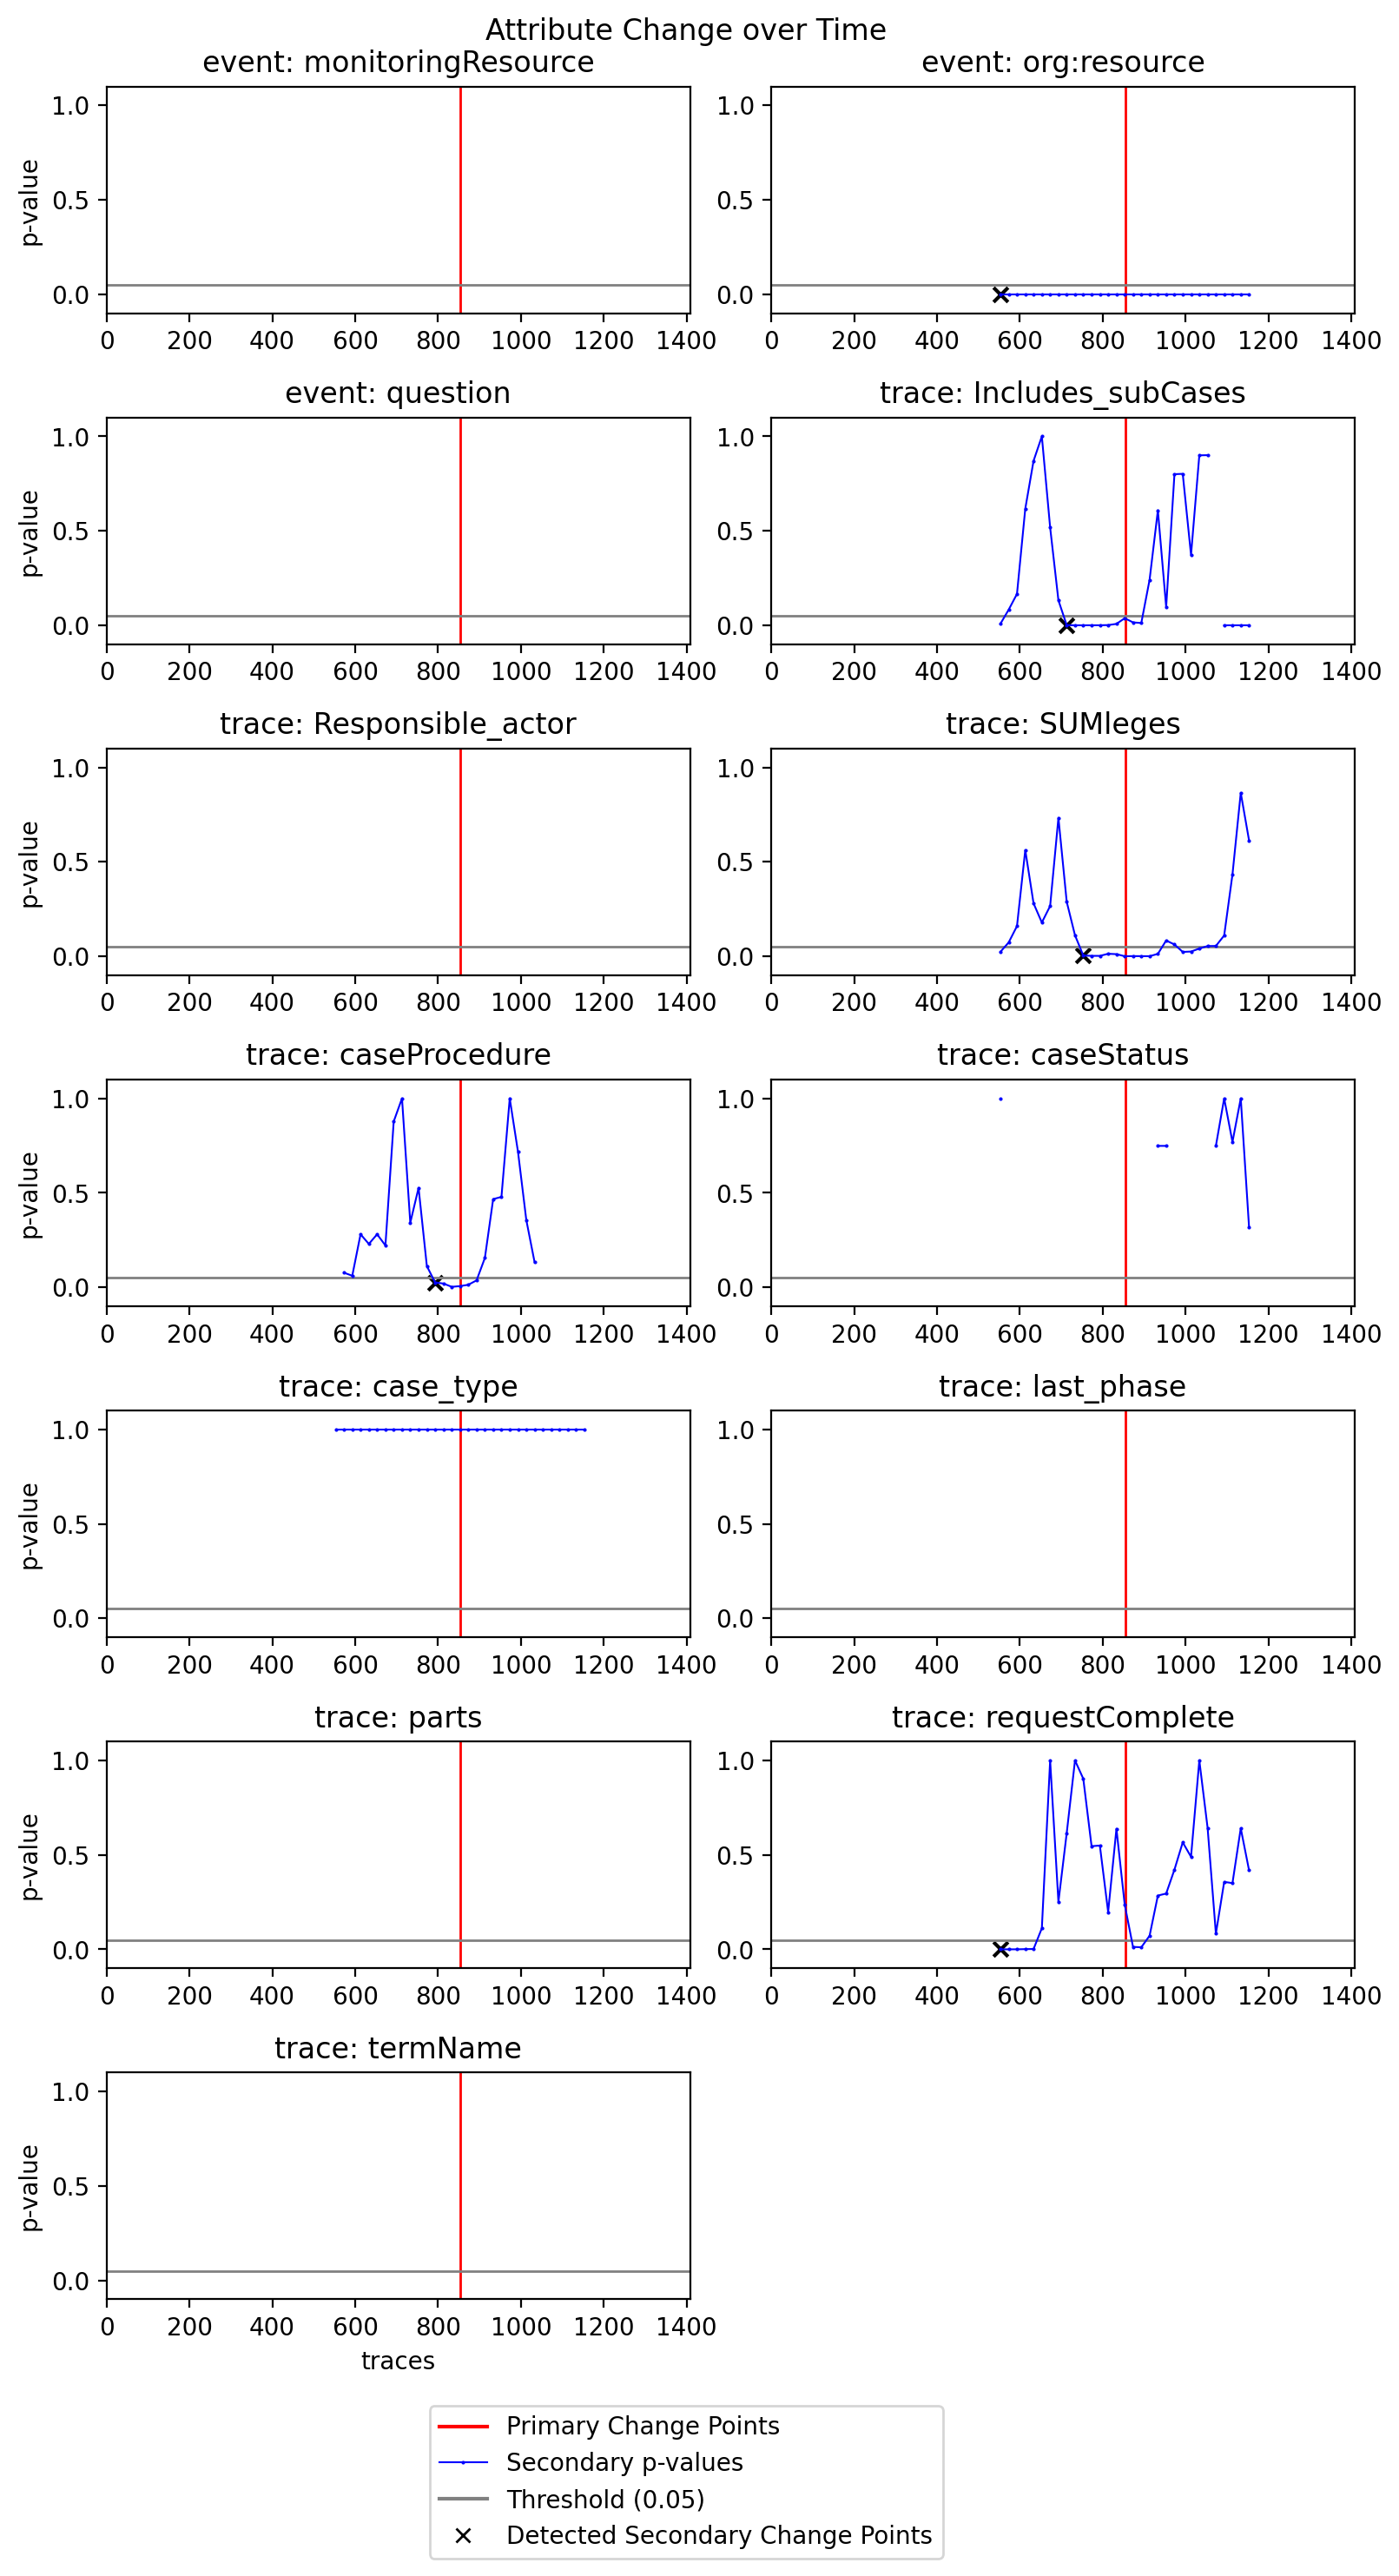

[854]


In [ ]:
# plot the change point explanations for municipal 3
changes_per_mun['mun_3'].plot(offset_legend=-0.07)
print(changes_per_mun['mun_3'].primary_dd_result.change_points)
pass

For municipal 3, the situation is comparable to that of municipal 1 - the change detectors are very sensitive and many are continuously below the threshold. However, visual analysis shows that the attributes 'case procedure', 'Includes_subCases', 'caseStatus' and 'request complete' show temporary drops in p-value close to the primary change point. Therefore, these attributes will be considered further in later analysis.

## Rerun the Secondary Drift Detection with another Population Comparison that is less sensitive (Hellinger's Distance)

In [ ]:
for secondary_drift_detector in secondary_drift_detectors:
    secondary_drift_detector.population_comparer = population_comparison.HellingerDistancePC()

hellinger_distance_explanations = {}
for mun in ['mun_1', 'mun_3']:
    primary_change_points = changes_per_mun[mun].primary_dd_result.change_points
    primary_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    hellinger_distance_explanations[mun] = changes

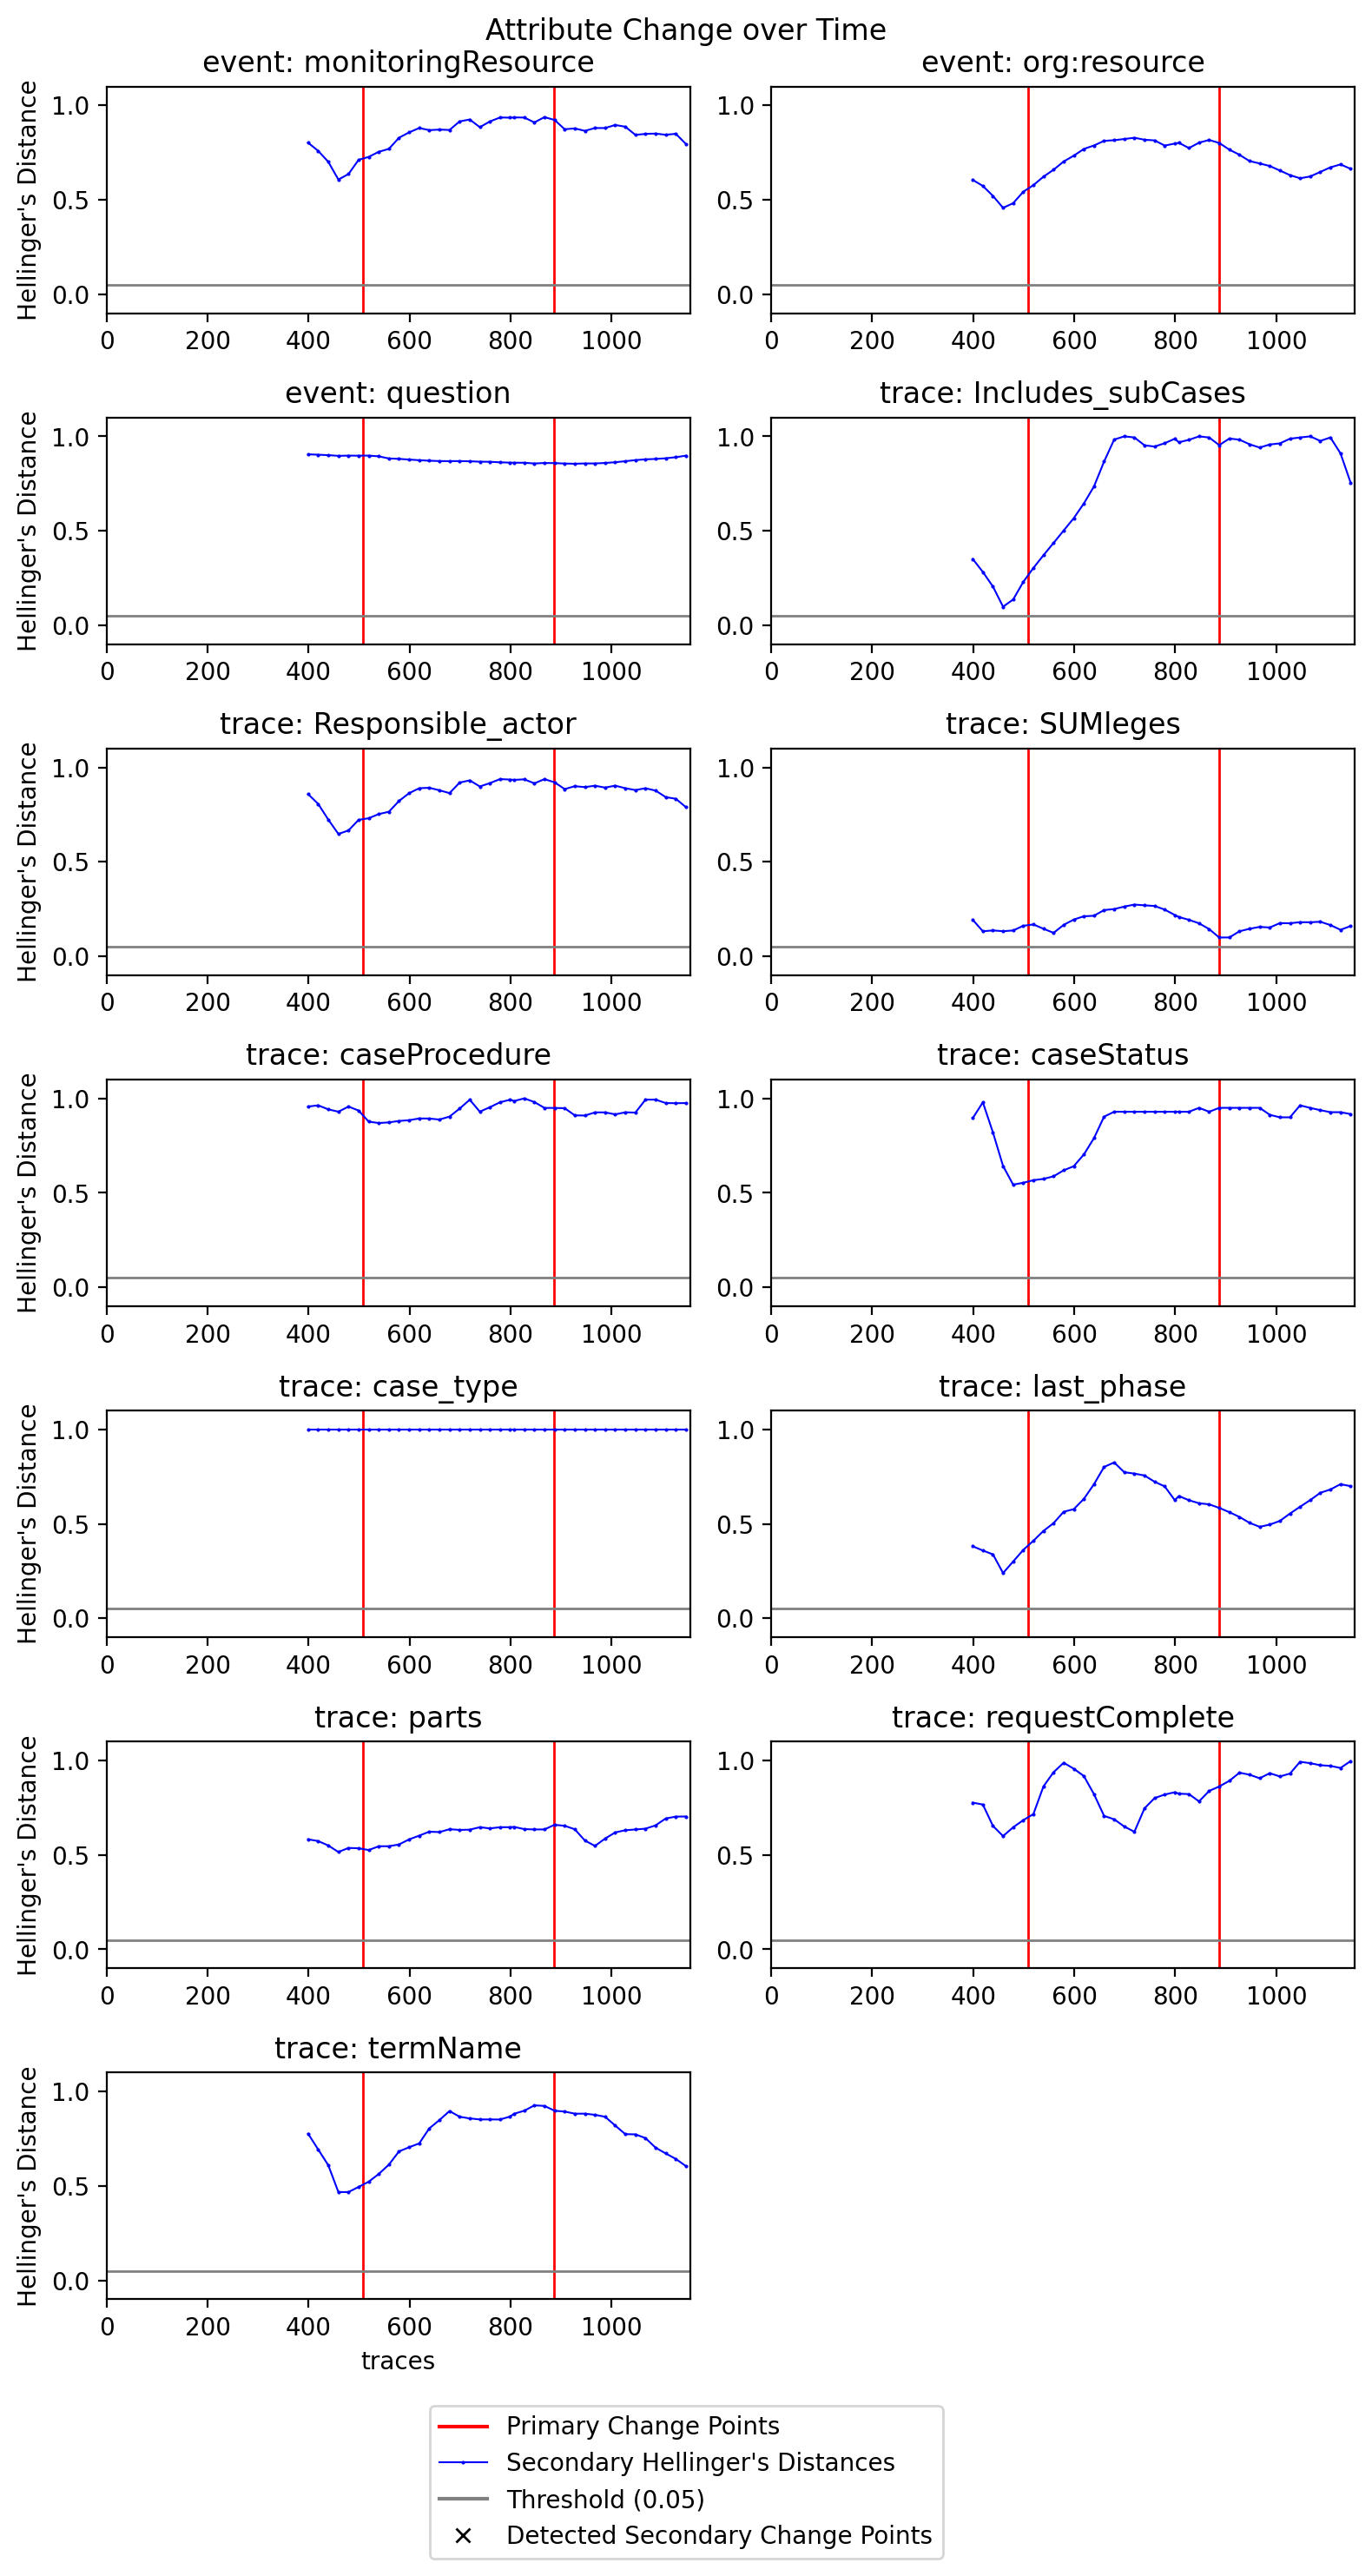

In [ ]:
hellinger_distance_explanations['mun_1'].plot(ylabel='Hellinger\'s Distance', offset_legend=-0.07)
pass

'Includes_subCases' shows a strong drop in similarity measure right before the first change point. This feature should be investigated further. The same goes for 'caseStatus'.
'last_phase' has a drop before the first change point and right after the second. The curve of 'last_phase' mirrors that of 'org:resource'.
'termName' also has a drop in Hellinger's distance before the change point.

In [ ]:
# helper.compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'caseStatus', 0, 400)

In [ ]:
# helper.compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'Includes_subCases', 0, 400)

In [ ]:
# helper.compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'last_phase', 0, 400)

In [ ]:
helper.compare_attributes_in_windows(event_logs['mun_1'], 'event', 'org:resource', 0, 400)

AttributeError: module 'helper' has no attribute 'compare_attributes_in_windows'

In [ ]:
helper.compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'termName', 0, 400)

Analysis of trace attribute termName
Values in Window a


Termijn bezwaar en beroep 1                113
Termijn tot besluit                         42
Attribute not defined.                      29
Termijn tot bezwaar buiten behandeling       9
Termijn aanvullende gegevens                 3
Termijn tot besluit omgezet 2                1
Termijn tot besluit na geen zienswijzen      1
Termijn tot besluit omgezet                  1
Termijn tot besluit verlengd                 1
dtype: int64

Values in Window b


Termijn bezwaar en beroep 1                128
Attribute not defined.                      34
Termijn tot besluit                         26
Termijn aanvullende gegevens                 4
Termijn tot besluit verlengd                 3
Termijn tot besluit omgezet                  2
Termijn bezwaar en beroep 2                  1
Termijn tot besluit na geen zienswijzen      1
Termijn ter inzage buiten behandeling        1
dtype: int64

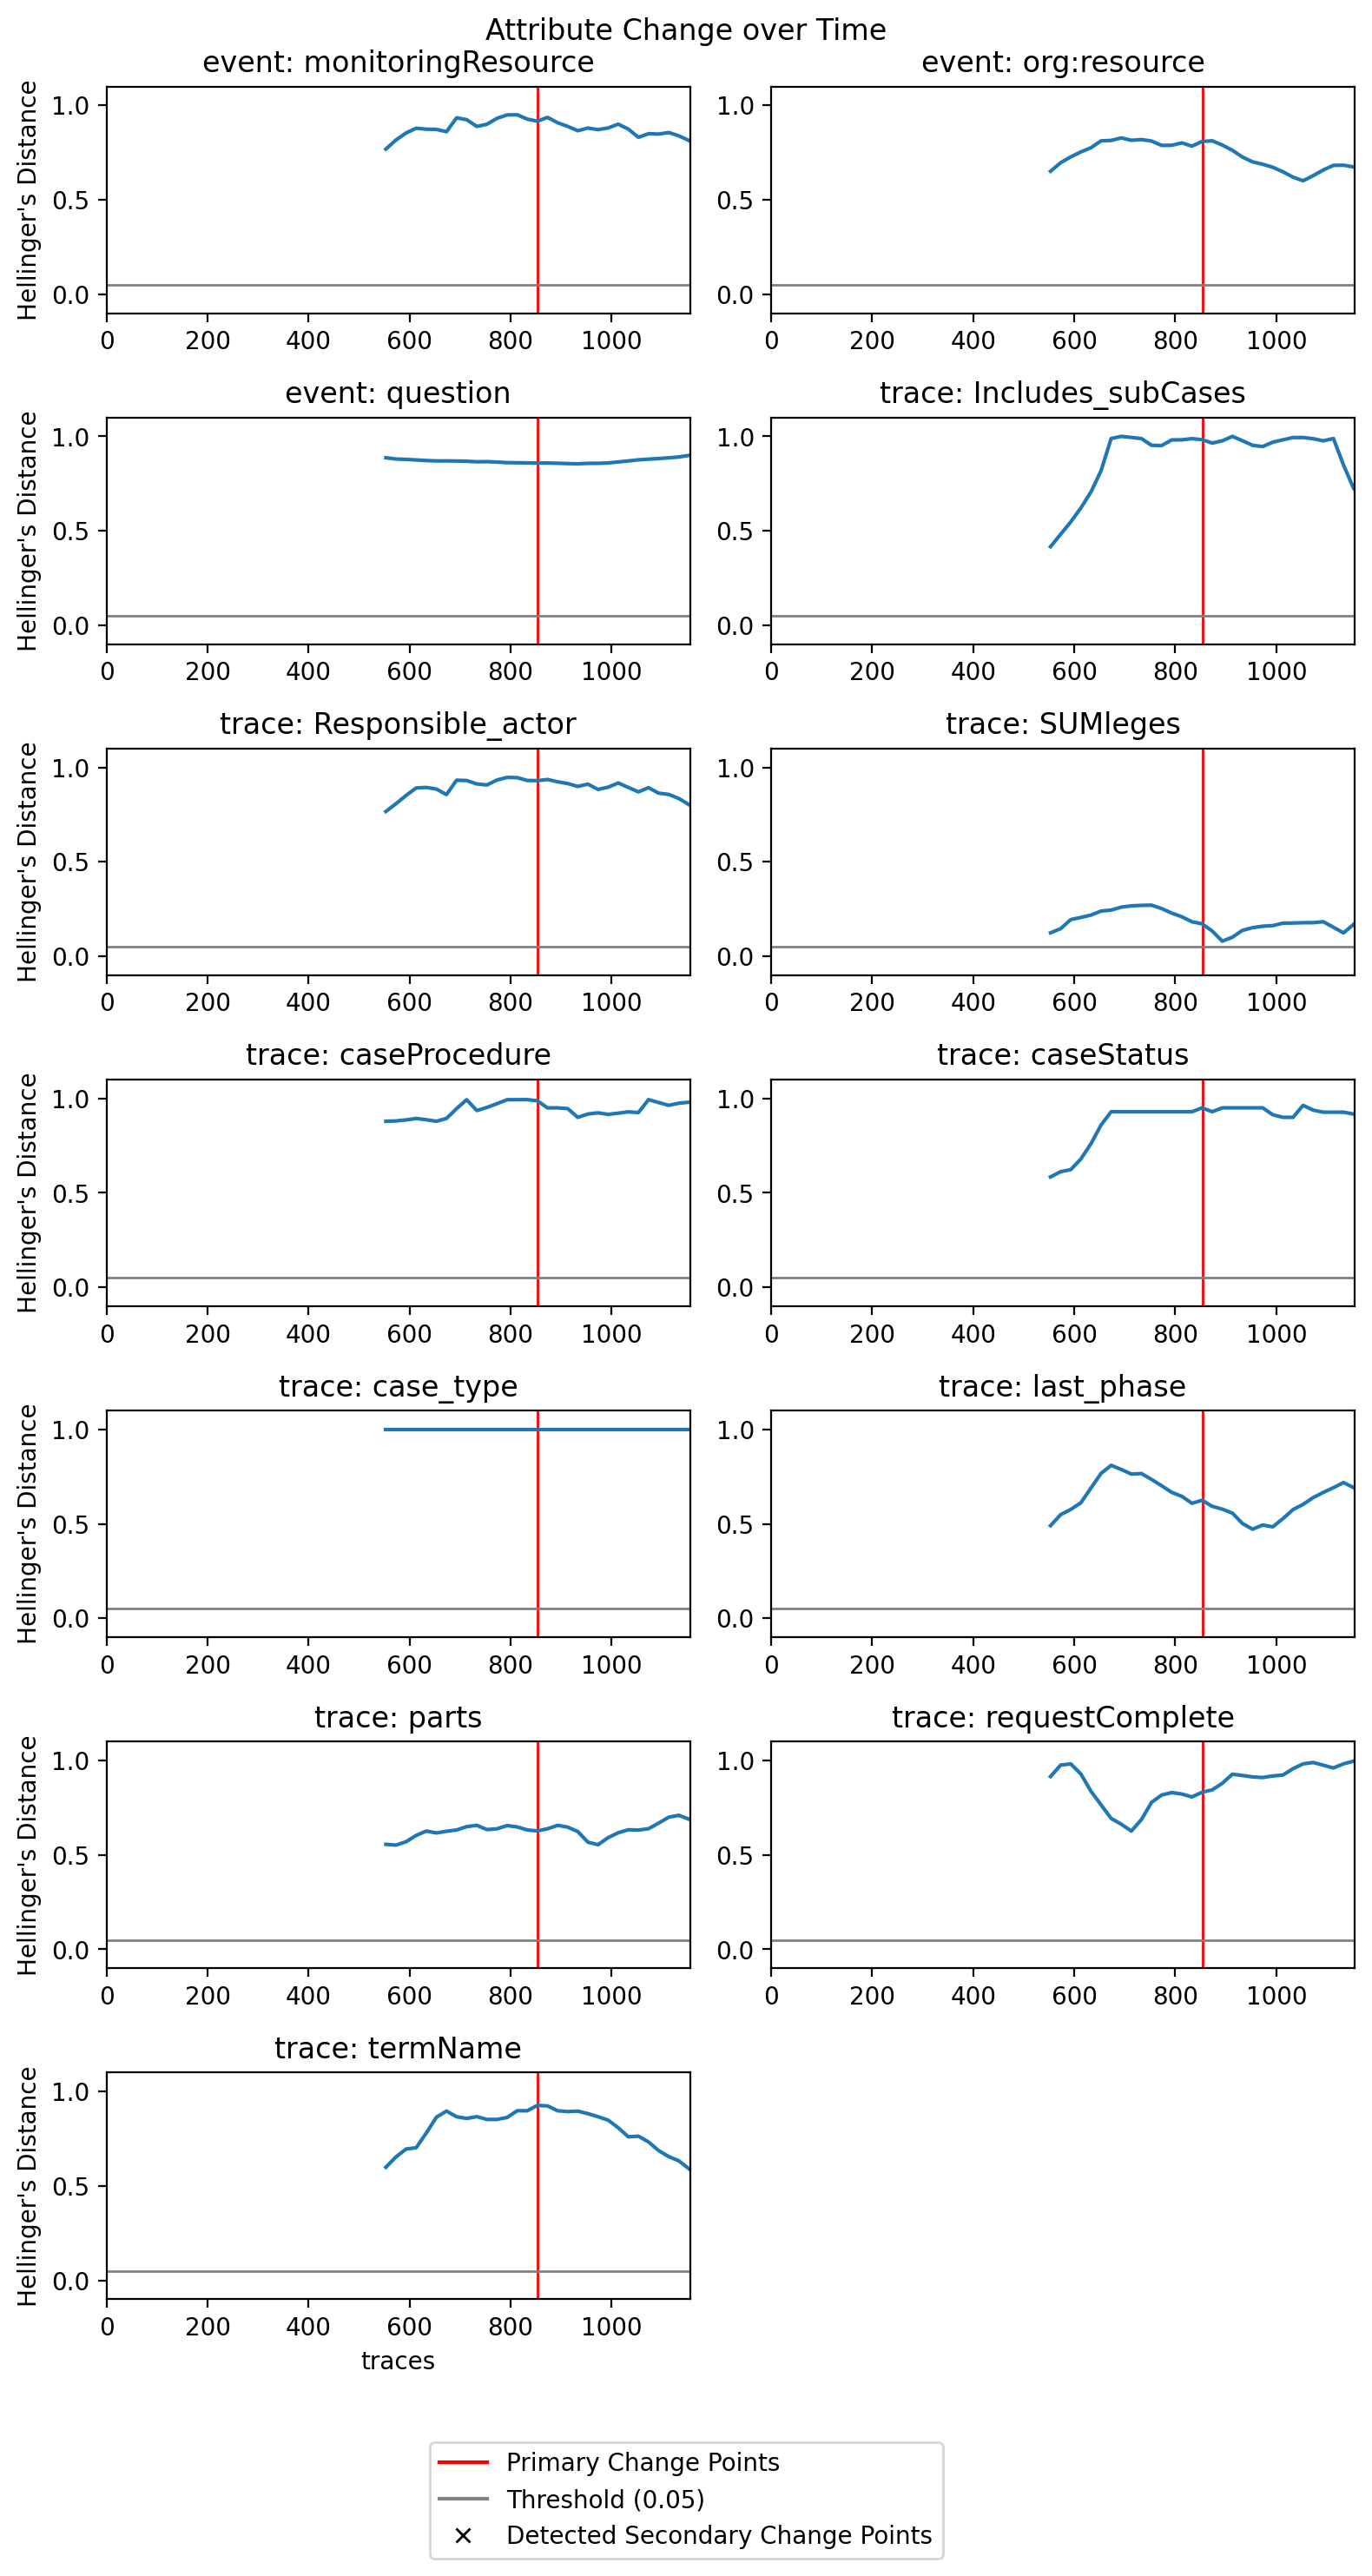

In [ ]:
hellinger_distance_explanations['mun_3'].plot(ylabel='Hellinger\'s Distance', offset_legend=-0.07)
pass

In [ ]:
helper.compare_attributes_in_windows(event_logs['mun_1'], 'trace', 'last_phase', 450, 1000, window_width=100)

Analysis of trace attribute last_phase
Values in Window a


Vergunning verleend       77
Procedure afgebroken      11
Aanvraag ontvangen         5
Ontwerpbesluit genomen     2
Aanvraag ontvankelijk      1
Besluit onherroepelijk     1
Beschikking verzonden      1
Besluit genomen            1
Advies bekend              1
dtype: int64

Values in Window b


Beschikking verzonden              57
Zaak afgehandeld                   24
Besluit onherroepelijk              9
Procedure afgebroken                4
Buiten behandeling gelaten          3
Procedure tussentijds beëindigd     1
Advies bekend                       1
Aanvullende gegevens ontvangen      1
dtype: int64

In [ ]:
helper.compare_attributes_in_windows(event_logs['mun_3'], 'trace', 'requestComplete', 400, 600, window_width=100)

Analysis of trace attribute requestComplete
Values in Window a


TRUE     72
FALSE    28
dtype: int64

Values in Window b


TRUE     80
FALSE    20
dtype: int64

In [ ]:
for secondary_drift_detector in secondary_drift_detectors:
    secondary_drift_detector.population_comparer = population_comparison.ChiSquaredPC()
    secondary_drift_detector.window_generator = windowing.FixedWG(200)

chi_squared_explanations = {}
for mun in ['mun_1', 'mun_3']:
    primary_change_points = changes_per_mun[mun].primary_dd_result.change_points
    primary_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    chi_squared_explanations[mun] = changes

In [ ]:
chi_squared_explanations

{'mun_1': <processdrift.framework.drift_explanation.DriftExplanationResult at 0x268f7fdc370>,
 'mun_3': <processdrift.framework.drift_explanation.DriftExplanationResult at 0x268f97e85b0>}

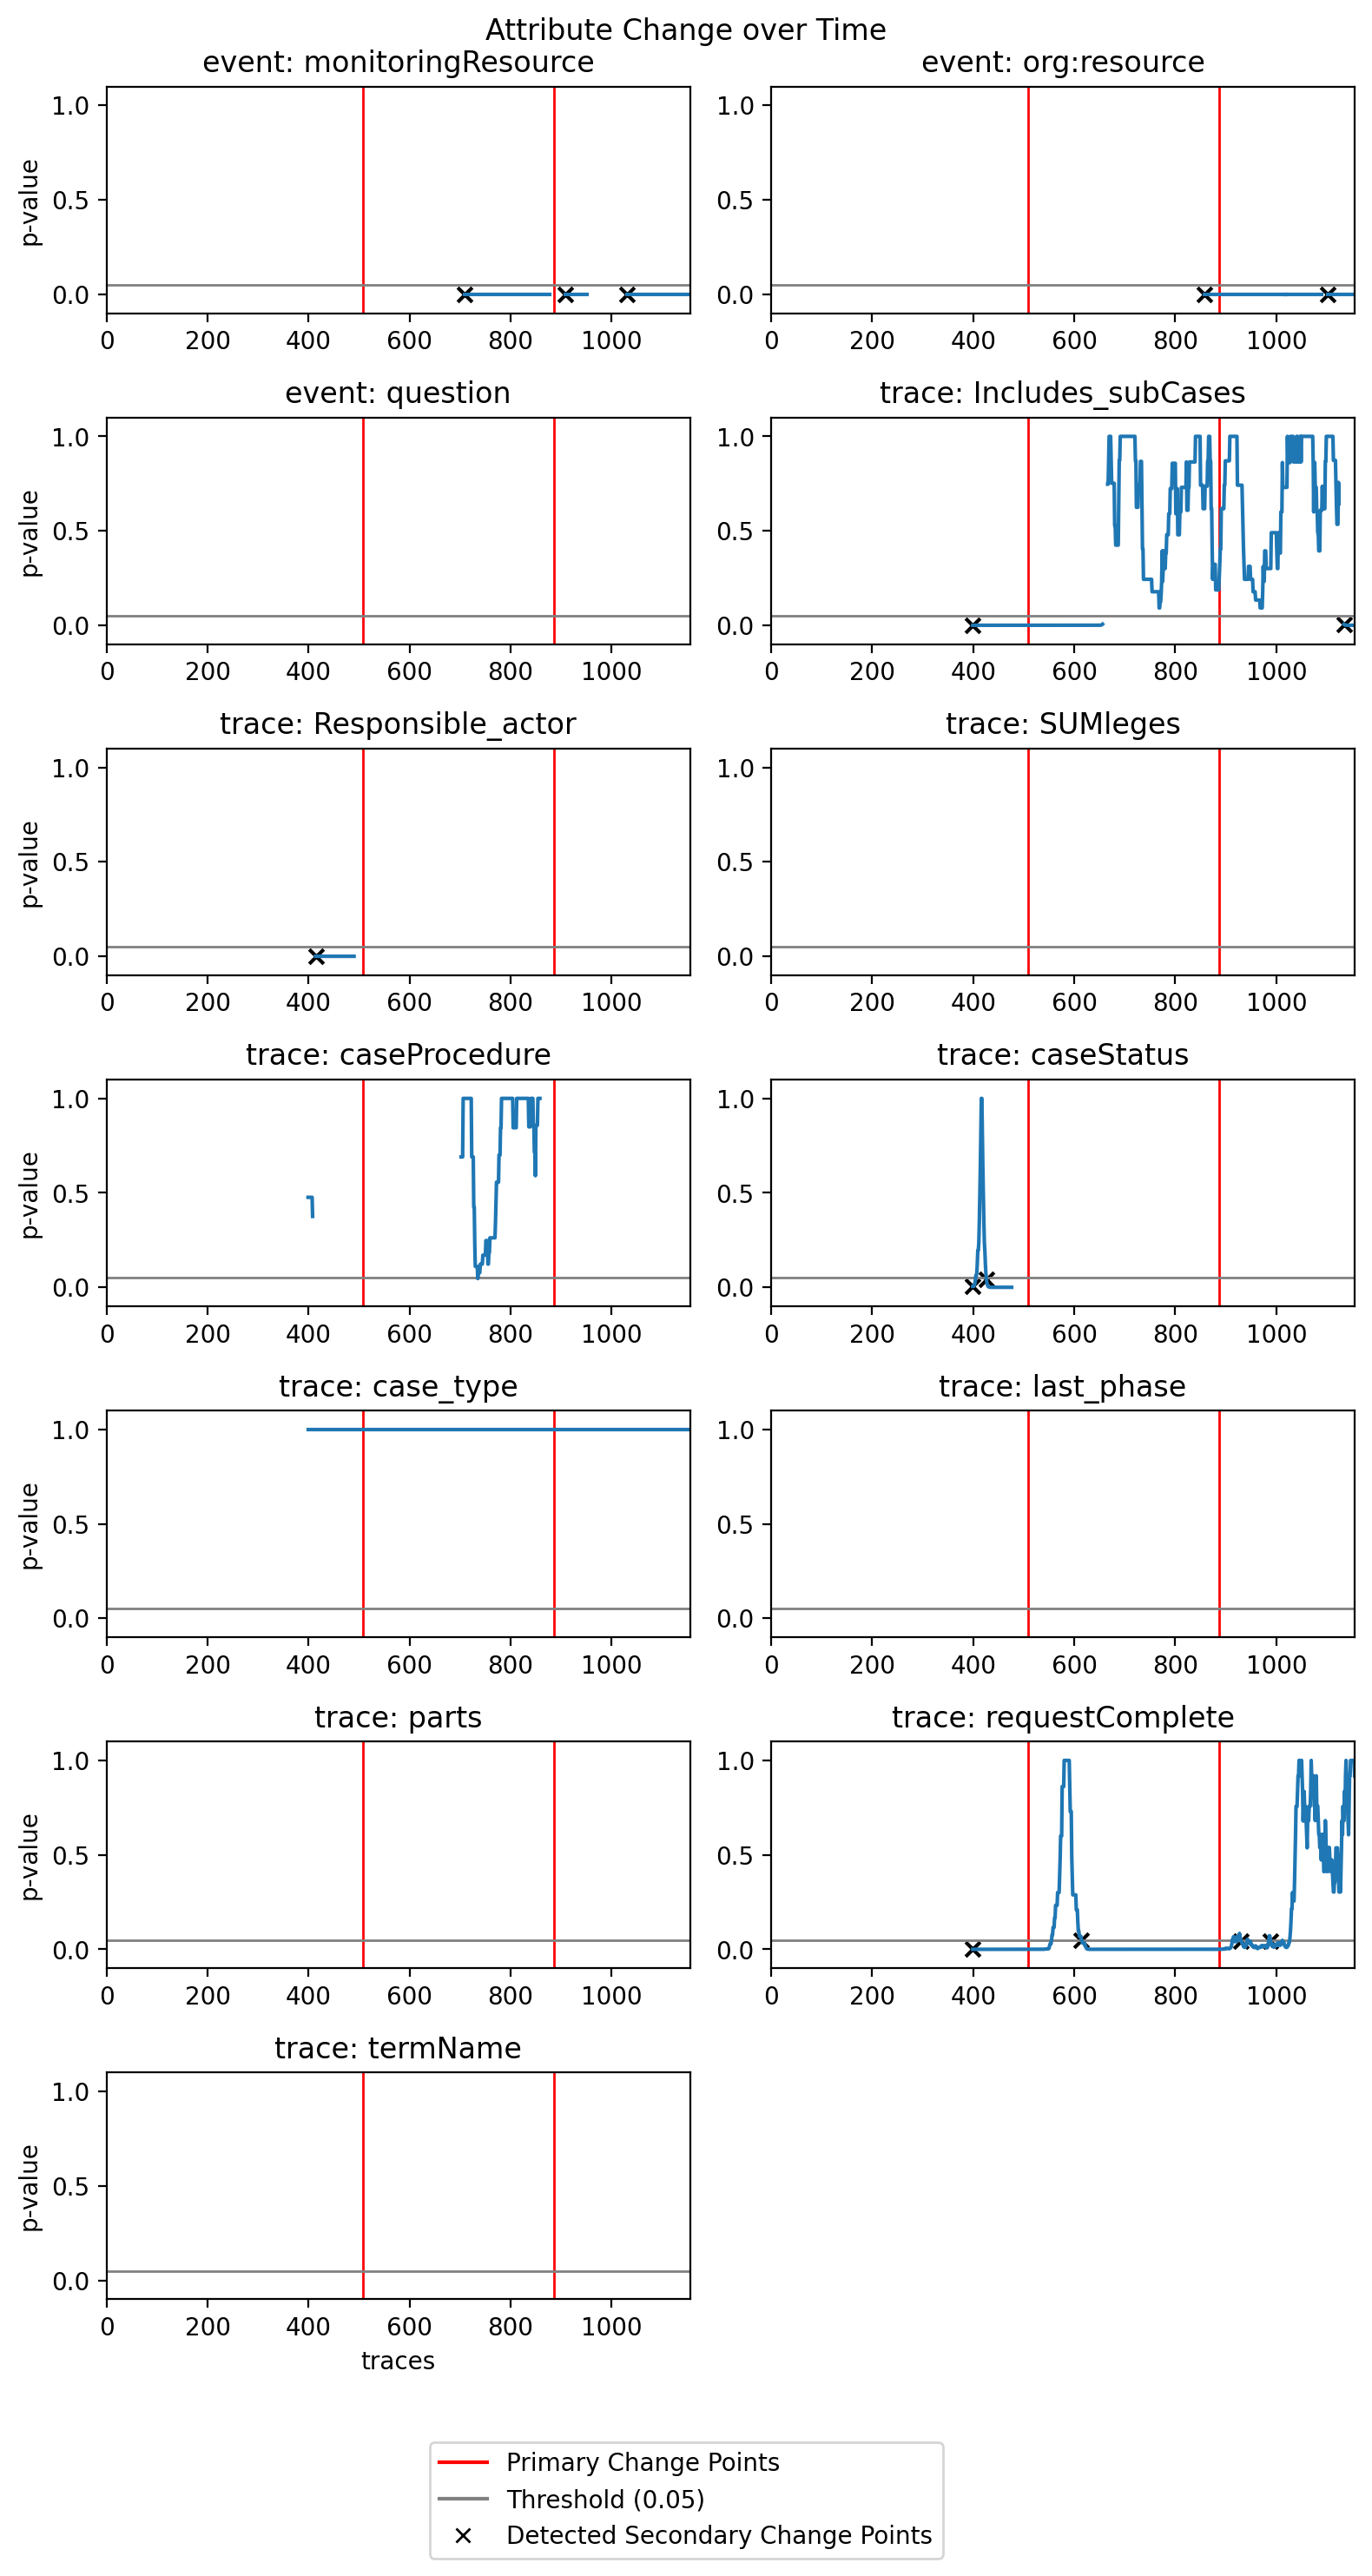

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
chi_squared_explanations['mun_1'].plot(ylabel='p-value', offset_legend=-0.07)

In [ ]:
for secondary_drift_detector in secondary_drift_detectors:
    secondary_drift_detector.population_comparer = population_comparison.GTestPC()
    secondary_drift_detector.window_generator = windowing.FixedWG(300)

larger_windows_explanations = {}
for mun in ['mun_1', 'mun_3']:
    primary_change_points = changes_per_mun[mun].primary_dd_result.change_points
    primary_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    larger_windows_explanations[mun] = changes

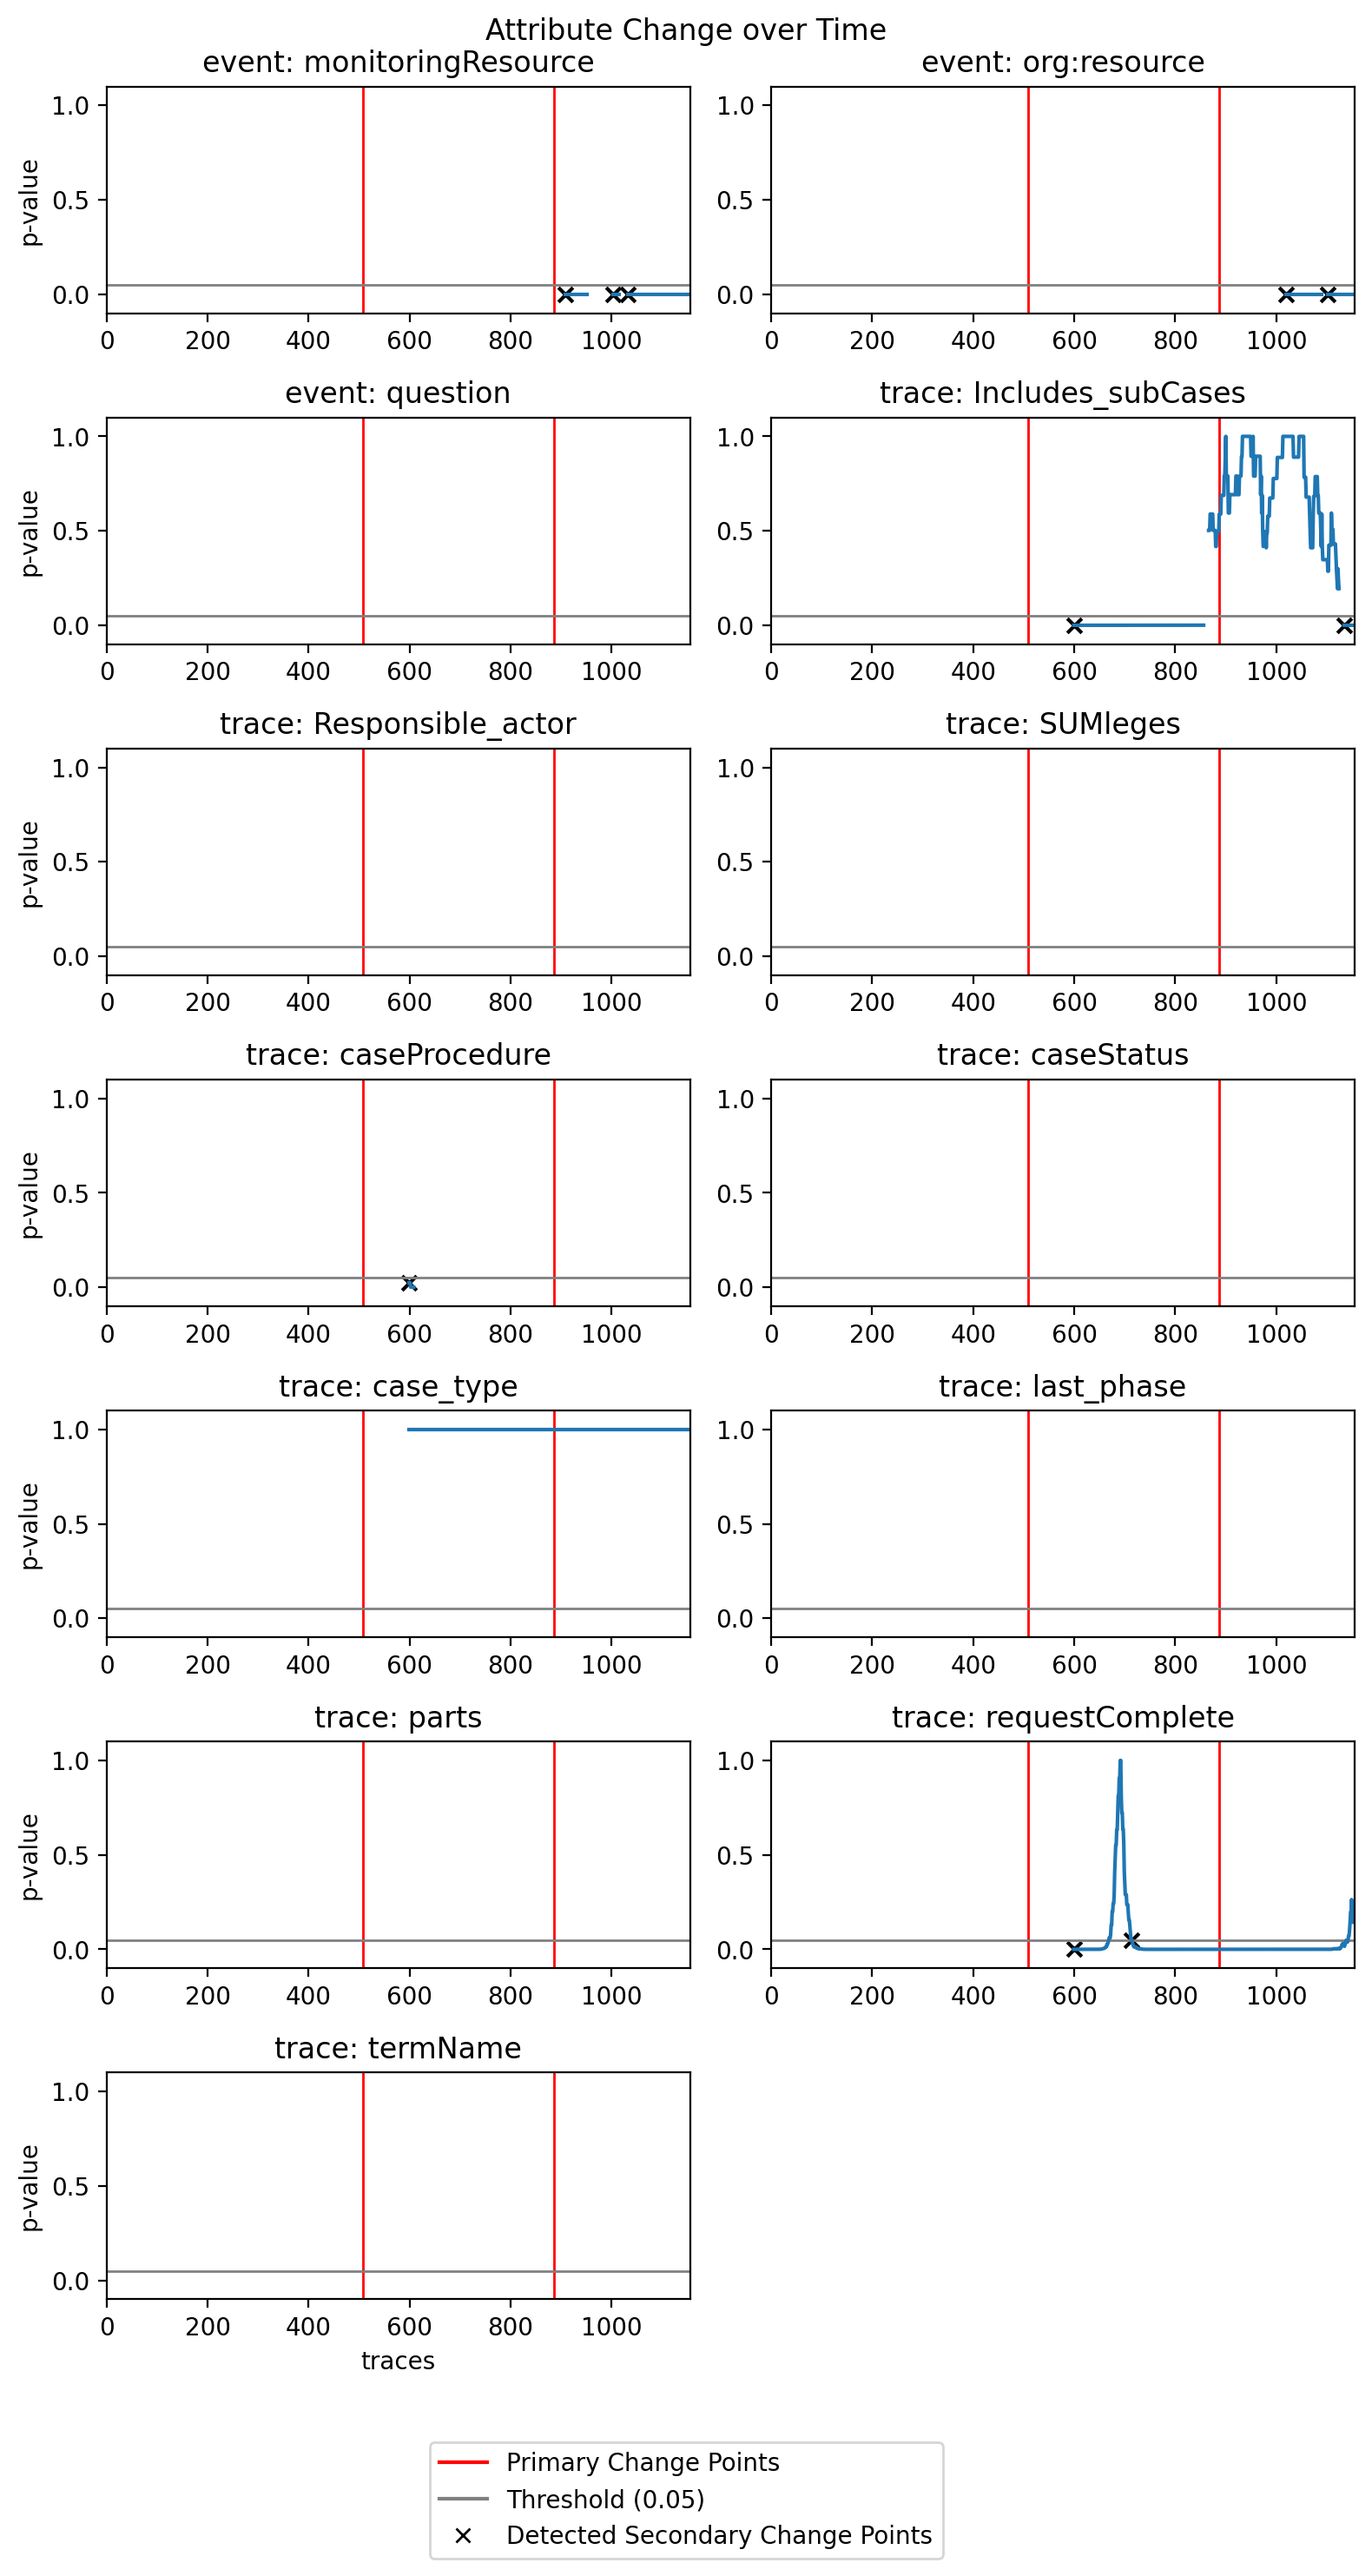

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
larger_windows_explanations['mun_1'].plot(ylabel='p-value', offset_legend=-0.07)

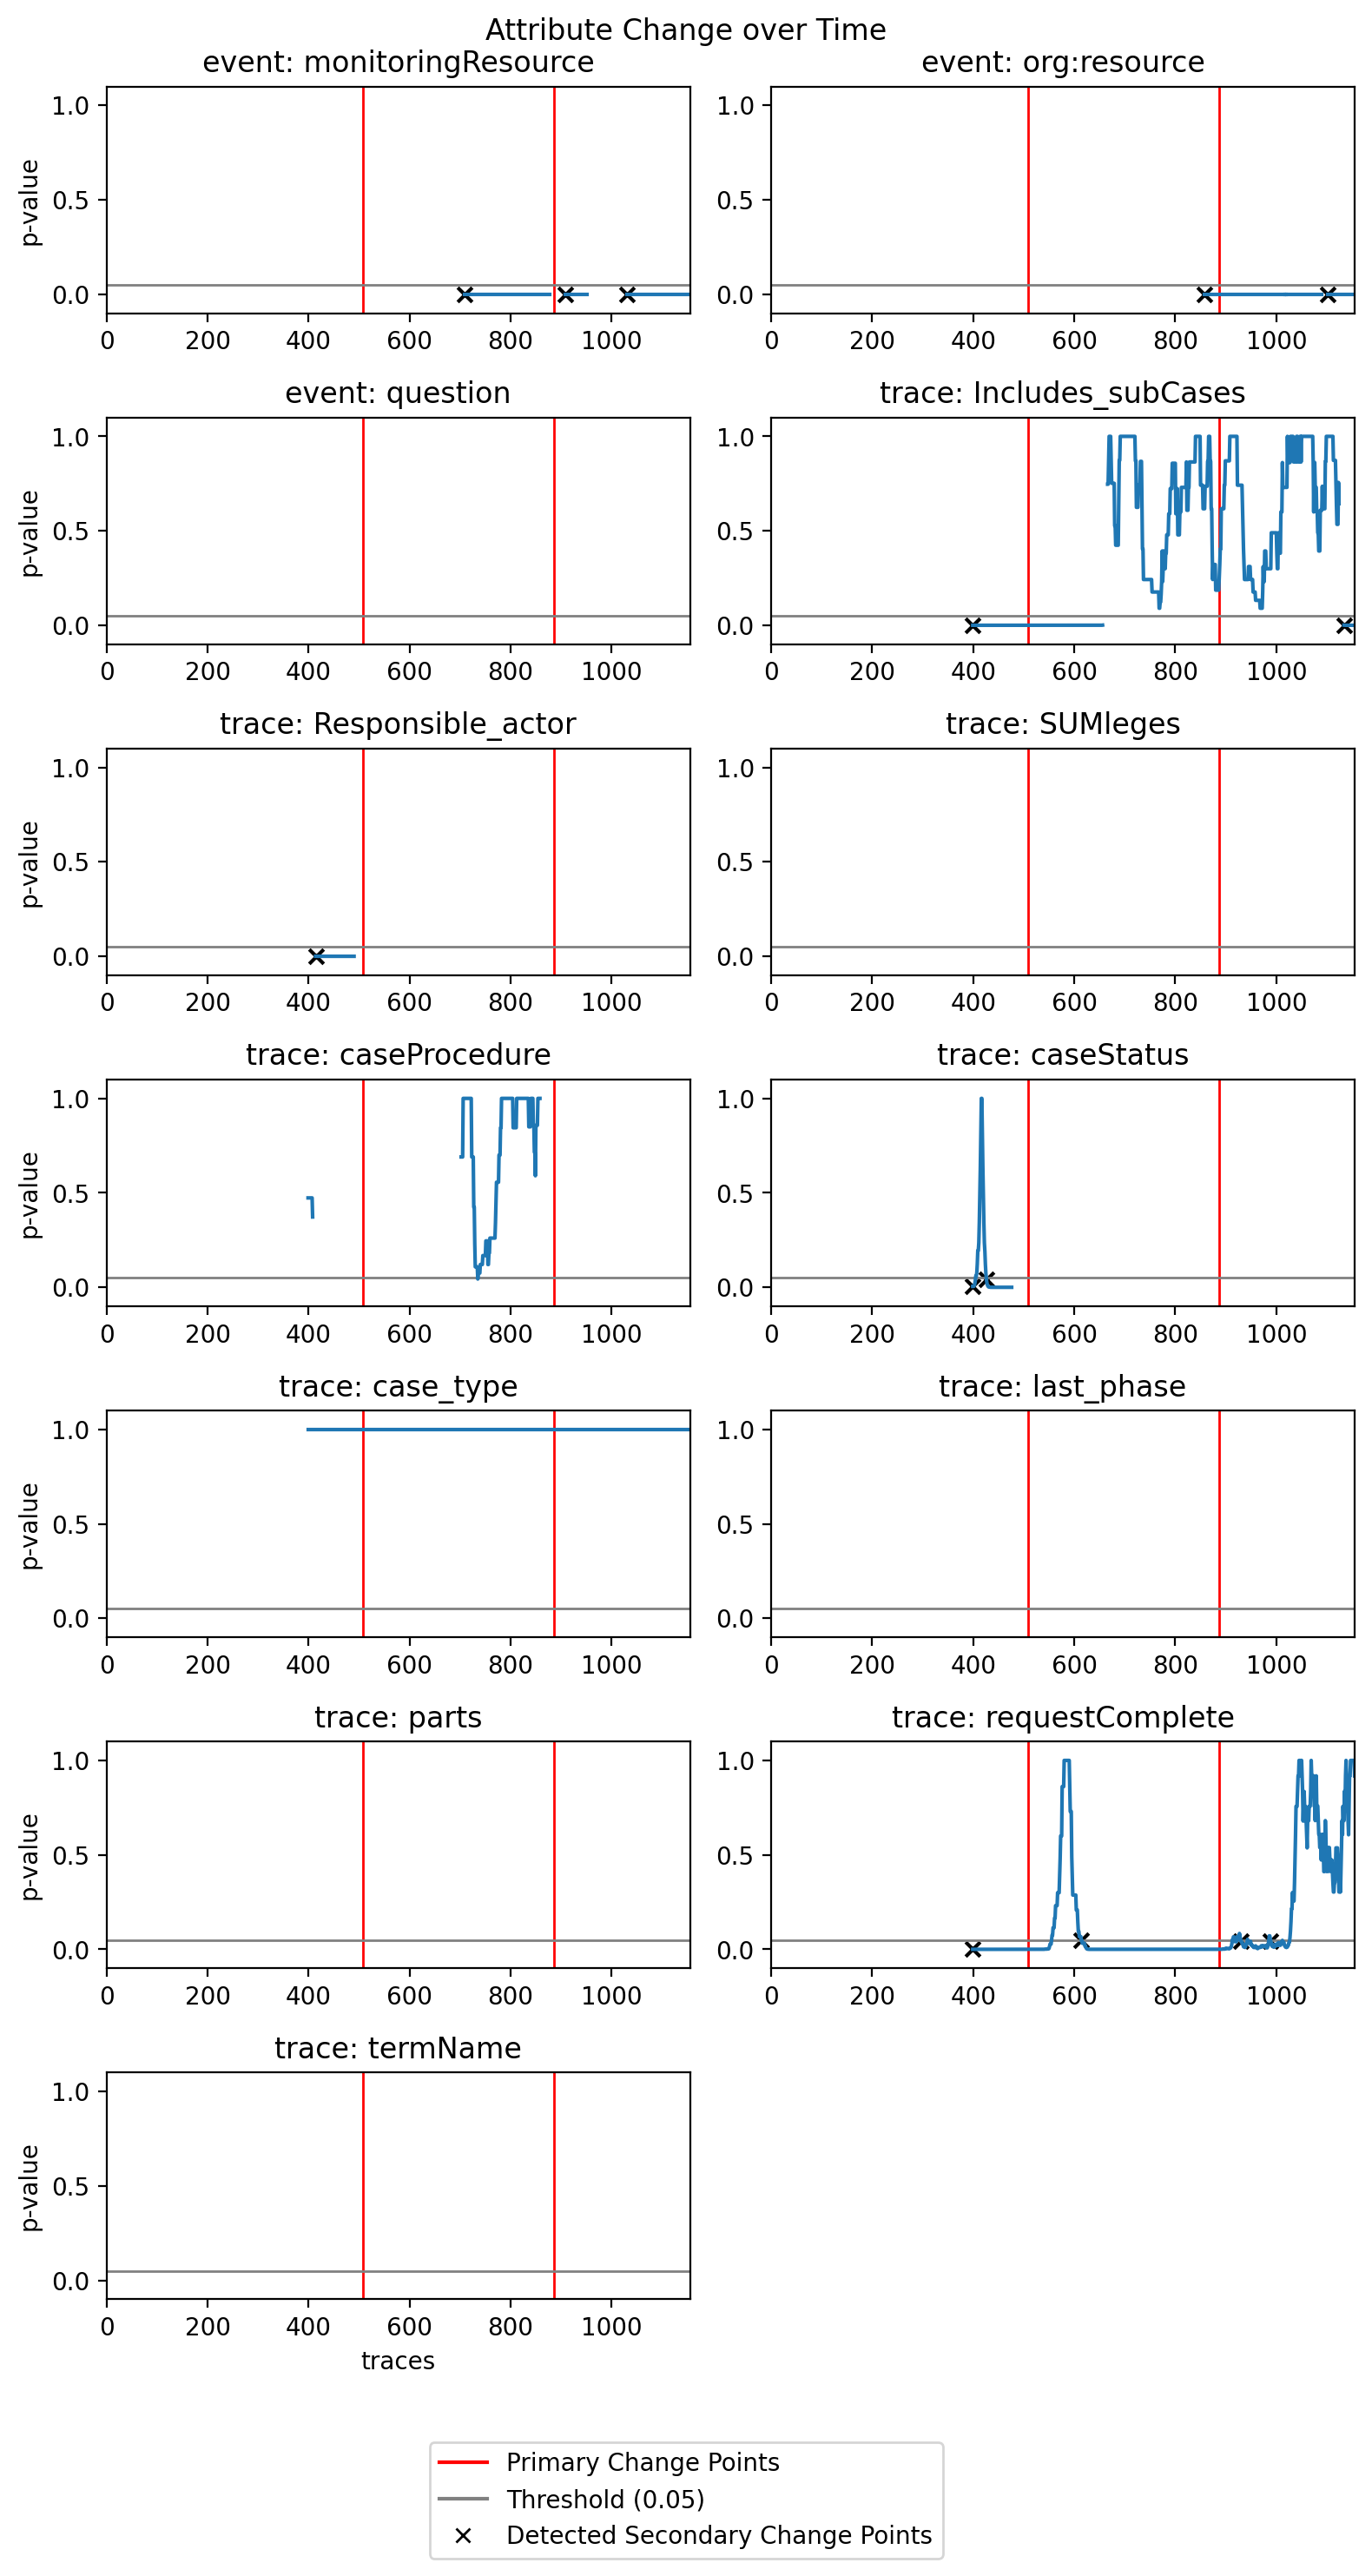

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
for secondary_drift_detector in secondary_drift_detectors:
    secondary_drift_detector.population_comparer = population_comparison.GTestPC(5)
    secondary_drift_detector.window_generator = windowing.FixedWG(200)

g_min_samples_explanations = {}
for mun in ['mun_1', 'mun_3']:
    primary_change_points = changes_per_mun[mun].primary_dd_result.change_points
    primary_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

    # create the change point explainer
    drift_explainer = drift_explanation.DriftExplainer(primary_drift_detector, secondary_drift_detectors)

    # get the change point explanations
    changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
    g_min_samples_explanations[mun] = changes

g_min_samples_explanations['mun_1'].plot(ylabel='p-value', offset_legend=-0.07)

In [ ]:
from cProfile import label
import math
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import lines
import pandas as pd


def plot(self, columns=2,
        plot_primary_change_series=False,
        plot_annotations=False,
        threshold=0.05,
        offset_legend=-0.15,
        ylabel='p-value'):
        """Plots the primary and secondary change series returned by DriftExplainer.get_primary_and_secondary_changes(event_log).
    
        Args:
            columns: Number of columns
            plot_primary_change_series: Whether or not to plot the primary change series.
            plot_annotations: Whether or not to plot annotations for each change point.
            threshold: Value or p-value threshold.
            offset_legend: Vertical offset of the plot's legend.
        
        Returns:
            Plot.
        """
        # get the primary and secondary change
        primary_change_points = self.primary_dd_result.change_points
        primary_change_series = self.primary_dd_result.change_series
        secondary_change_dict = self.secondary_dd_result_dictionary
        
        n = len(secondary_change_dict.keys())
        rows = max(1, int(math.ceil(n / columns))) # set the row count to at least 1

        gs = gridspec.GridSpec(rows, columns)
        fig = plt.figure(dpi=200, figsize = (8,2*rows))
        
        # get sorted attribute list
        attribute_list = sorted(list(secondary_change_dict.keys()))
        
        # plot all secondary values
        for i, attribute_name in enumerate(attribute_list):
            secondary_change_series = secondary_change_dict[attribute_name].change_series
            secondary_change_points = secondary_change_dict[attribute_name].change_points

            ax = fig.add_subplot(gs[i])
            
            # plot the change points by a red line
            for change_point in primary_change_points:
                plt.axvline(x=change_point, color='red', linewidth=1)

            # plot the threshold as a grey line
            if threshold is not None:
                plt.axhline(y=threshold, color='grey', linewidth=1)

            # based on user choice, plot the primary change series
            if plot_primary_change_series:
                ax.plot(primary_change_series, color='red', linestyle='dashed')

            plot_ax = ax.plot(secondary_change_series, color='blue', 
                                            marker=".", linewidth=0.75, markersize=1,
                                            label=f"Secondary {ylabel}s")
            
            secondary_change_line = plot_ax[0]
            
            x = secondary_change_points
            # check if there were secondary change points
            if x is not None:
                y = list(secondary_change_series.loc[secondary_change_points])
                ax.scatter(x=x, 
                    y=y,
                    marker='x',
                    color='black'
                )
            
            if plot_annotations:
                for i, secondary_change_point in enumerate(x):
                    change_point_trace = x[i]
                    change_point_y = y[i]
                    ax.annotate(f'({change_point_trace}, {change_point_y:.2f})', (x[i], y[i]))

            # set the y axis so all changes in the data can be clearly seen
            plt.ylim(-0.1, 1.1)
            plt.xlim(0, primary_change_series.index[-1])
            ax.title.set_text(attribute_name)

            # give a y label to all plots in first column
            if i % columns == 0:
                ax.set_ylabel(ylabel)

            # give x labels to last row
            # e.g. 2 columns and 3 rows
            # 1, 2, 3, 4 -> FALSE; 5, 6 -> True
            if math.ceil((i+1)/columns) == rows:
                ax.set_xlabel('traces')
        
        # add a title
        fig.suptitle('Attribute Change over Time')

        fig.tight_layout()
        
        # create the legend
        legend_elements = [
            lines.Line2D([0], [0], color='red', linestyle='solid', label='Primary Change Points'),
            secondary_change_line,
            lines.Line2D([0], [0], color='grey', linestyle='solid', label=f'Threshold ({threshold})'),
            lines.Line2D([0], [0], color='black', marker='x', linestyle='None', label=f'Detected Secondary Change Points')
        ]

        fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, offset_legend))
        
        plt.show()

        return plt

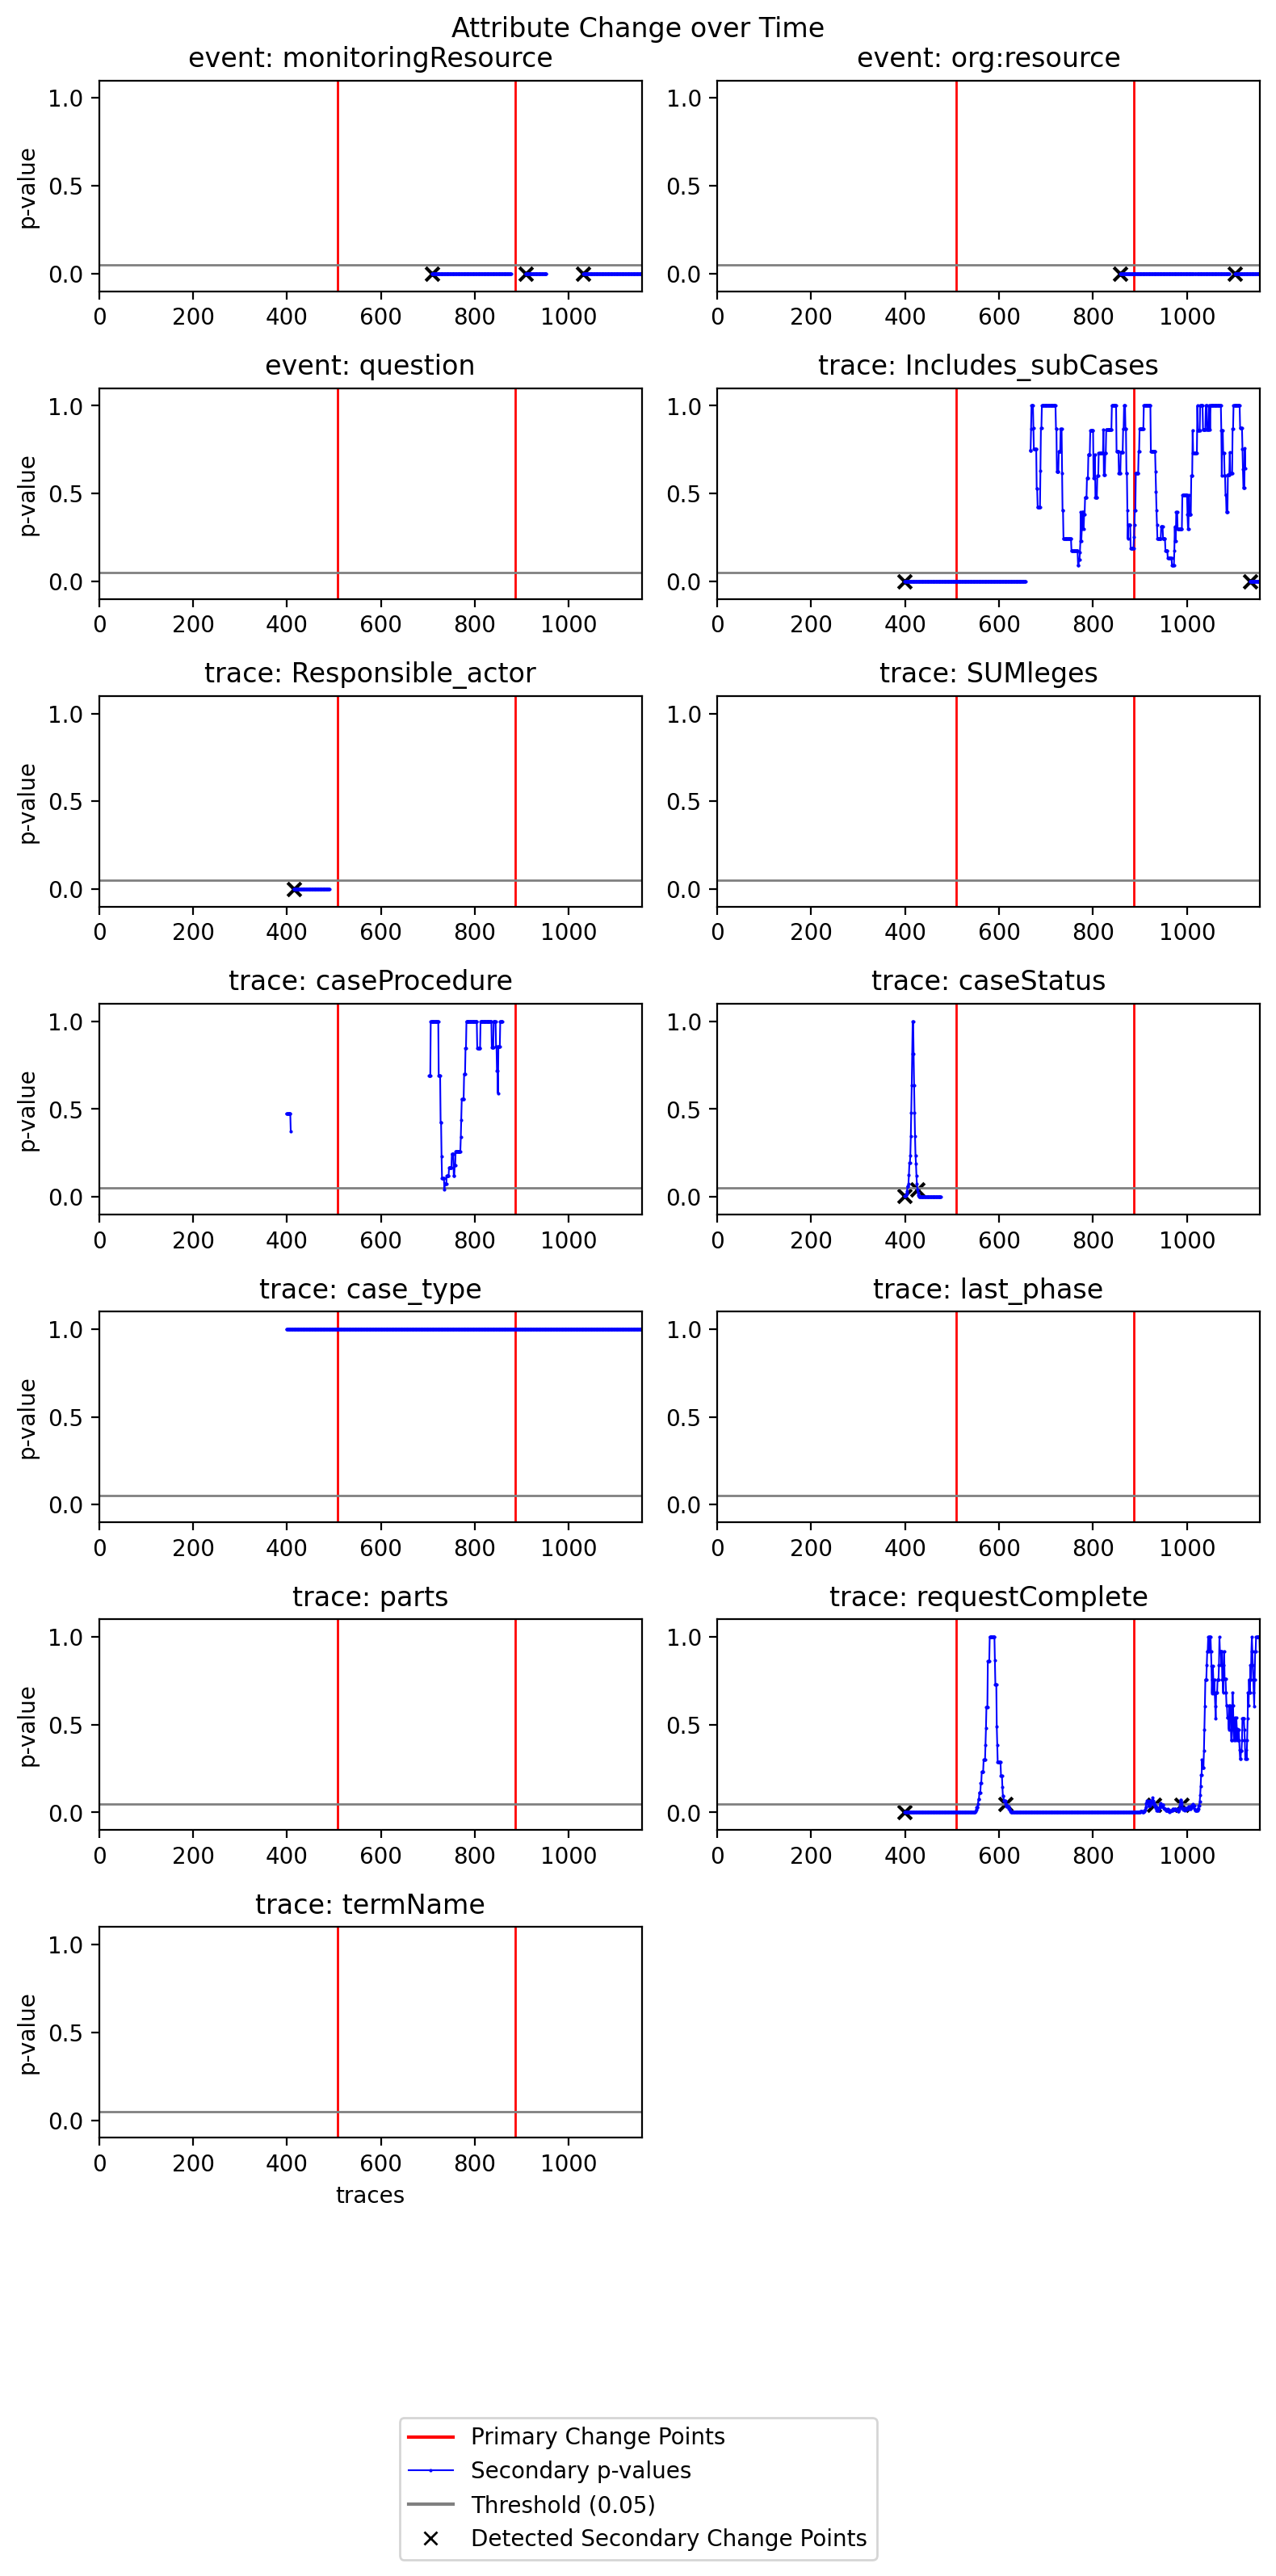

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
plot(g_min_samples_explanations['mun_1'])